# Homelessness data CA 2020-2024

**Goal:** make sense of available data and make predictions.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Homelessness count by age group and region

Age groups are self-explanatory. Regions are organized in Continuums of Care (CoCs) that can either match exactly one county, or regroup multiple counties, or, in the case of LA county, be a subset of a county.

In [2]:
df = pd.read_csv(
    'data/cy_age.csv',
    na_values='*',
    dtype={
        'AGE_GROUP_PUBLIC': pd.CategoricalDtype(
            categories=[
                'Under 18',
                '18-24',
                '25-34',
                '35-44',
                '45-54',
                '55-64',
                '65+',
                'Unknown',
                'Invalid',
            ],
            ordered=True,
        ),
    },
)
# Columns: CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT

### Over time

Let's start by plotting the number of persons experiencing homelessness year over year.

<Axes: xlabel='CALENDAR_YEAR', ylabel='EXPERIENCING_HOMELESSNESS_CNT'>

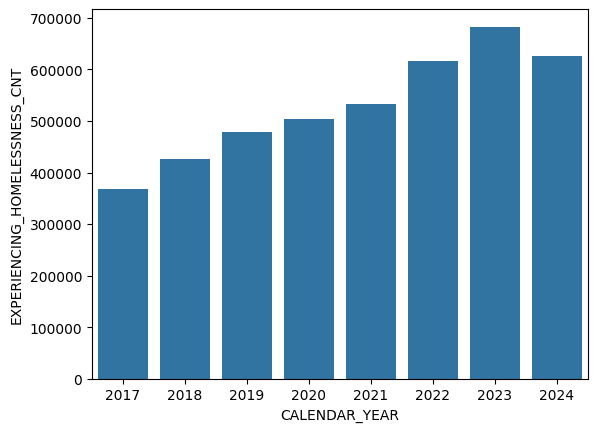

In [3]:
sns.barplot(
    df.groupby('CALENDAR_YEAR')[['EXPERIENCING_HOMELESSNESS_CNT']].sum(),
    x="CALENDAR_YEAR",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    # stack_y="LOCATION",
)

### By age group

Now let's plot the same thing but by age group.

<Axes: xlabel='CALENDAR_YEAR', ylabel='EXPERIENCING_HOMELESSNESS_CNT'>

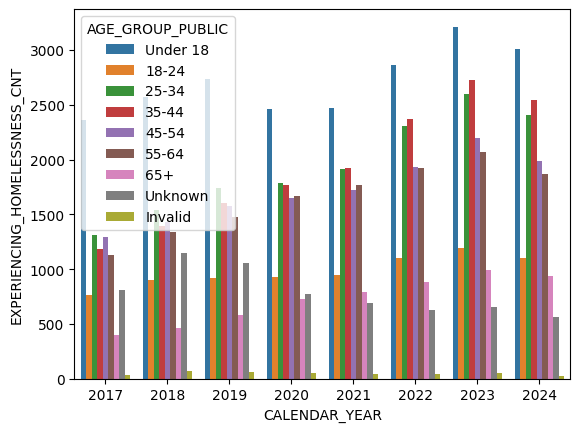

In [4]:
sns.barplot(
    df,
    x="CALENDAR_YEAR",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    hue="AGE_GROUP_PUBLIC",
    errorbar=None,
)

It's easier to visulize if we group by age groups first.

<Axes: xlabel='AGE_GROUP_PUBLIC', ylabel='EXPERIENCING_HOMELESSNESS_CNT'>

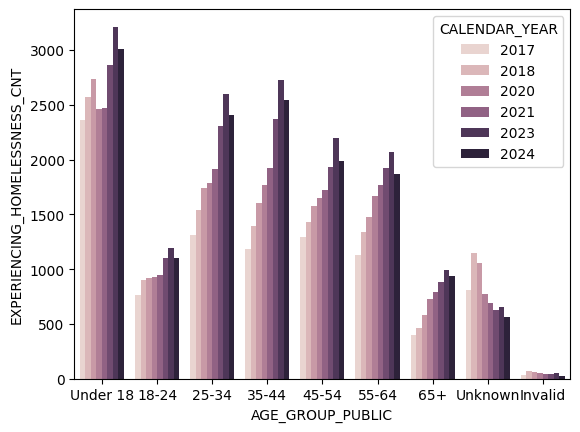

In [5]:
sns.barplot(
    df,
    x="AGE_GROUP_PUBLIC",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    hue="CALENDAR_YEAR",
    errorbar=None,
)

A stacked plot shows the progression year over year by age group while also showing the global trend.

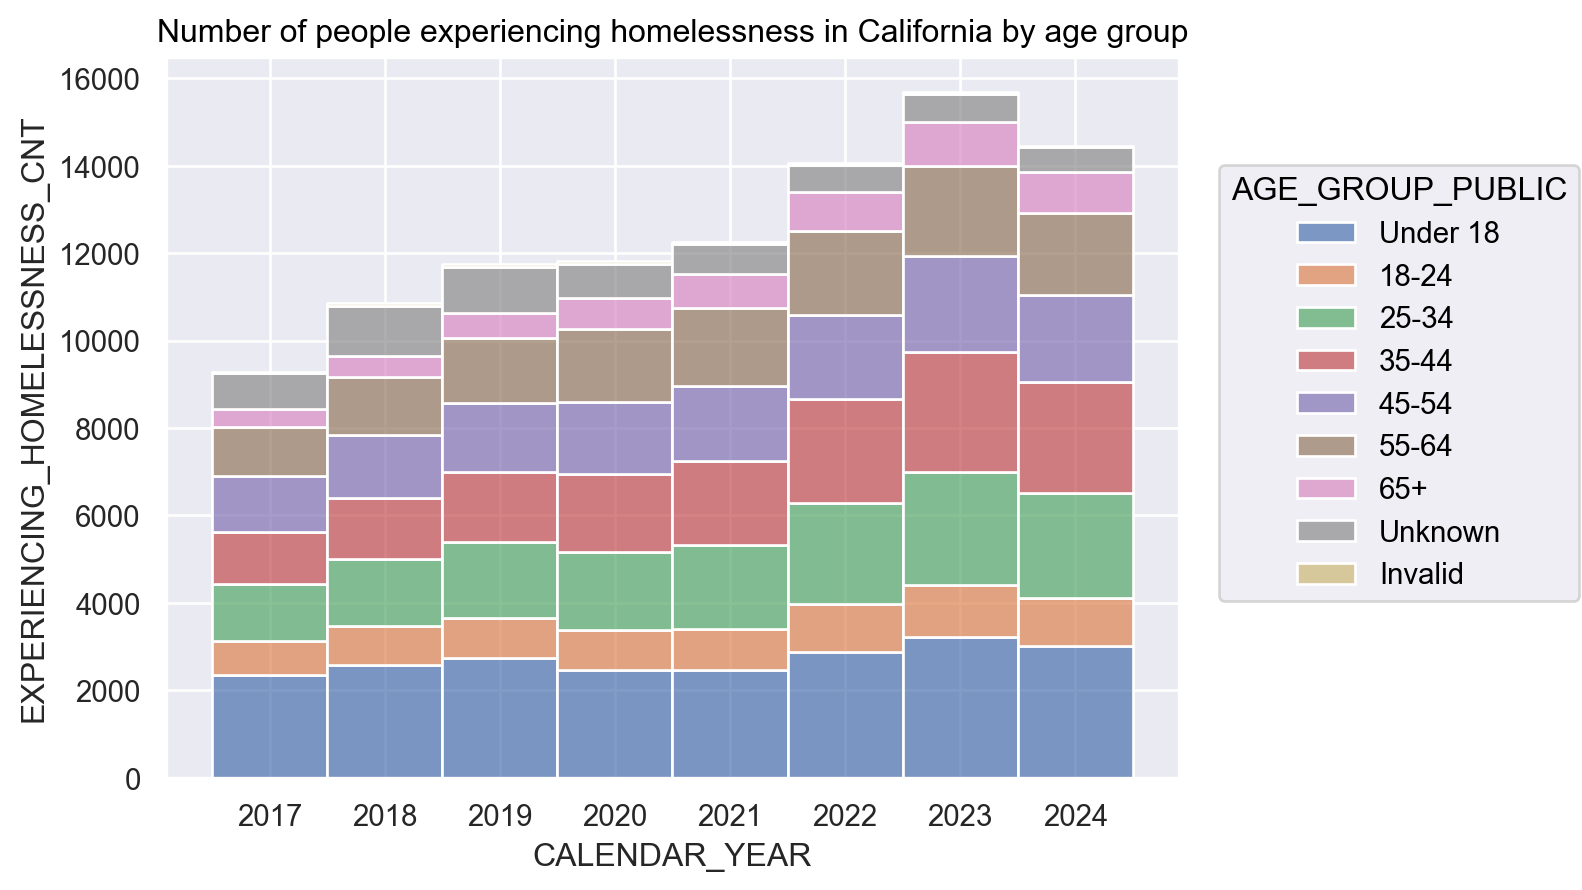

In [6]:
import seaborn.objects as so

so.Plot(
    df,
    x="CALENDAR_YEAR",
    y="EXPERIENCING_HOMELESSNESS_CNT",
    color="AGE_GROUP_PUBLIC",
).add(
    so.Bars(),
    so.Agg(),
    so.Stack(),
).scale(
    color=so.Nominal(
        order=[
            'Under 18',
            '18-24',
            '25-34',
            '35-44',
            '45-54',
            '55-64',
            '65+',
            'Unknown',
            'Invalid',
        ],
    )
).label(
    title="Number of people experiencing homelessness in California by age group"
)

## Load census data

We want to include total population data since it seems relevant to homeless population.

The census data I found only goes back to 2020 so let's ignore years 2017-2019 from now on.

In [7]:
census_df = pd.read_csv("data/census-ca-2020-2024.csv").drop('Base', axis=1)
census_df.head()

,County,2020,2021,2022,2023,2024
0,Alameda,1680614,1643856,1635693,1638142,1649060
1,Alpine,1179,1203,1169,1126,1099
2,Amador,40584,41245,41486,41798,42026
3,Butte,210222,206351,207384,207354,208334
4,Calaveras,45350,46262,46544,46580,46505


### Problem

Continuum of Care regions (CoCs) don't exactly map to counties.

Some CoCs span multiple counties (not a big problem) and some counties (Los Angeles) are split into multiple CoCs (big problem).

In [8]:
def extract_counties(region_str, all_county_list):
    """
    Extracts county names from a 'Region of Care' string.

    Args:
        region_str (str): The string describing the region of care.
        all_county_list (list): A list of all valid county names.

    Returns:
        list: A list of county names found in the region string.
              Returns all counties if region_str is 'California'.
    """
    if region_str == 'California':
        return all_county_list # Special case for the whole state

    clean_str = re.sub(r'\s+CoC.*$', '', region_str).strip()
    clean_str = re.sub(r'\s+Count(y|ies)$', '', clean_str).strip()
    counties = re.split(r',\s*|\s+and\s+', clean_str)

    extracted = [county.strip() for county in counties if county.strip()]

    if region_str in ['Long Beach CoC (Los Angeles County)',
                      'Pasadena CoC (Los Angeles County)',
                      'Glendale CoC (Los Angeles County)']:
        extracted = ['Los Angeles'] # Map these specific CoCs to Los Angeles County

    valid_counties = [c for c in extracted if c in all_county_list]
    if len(valid_counties) != len(extracted):
         print(f"Warning: Potential mismatch for region '{region_str}'. Extracted: {extracted}, Validated: {valid_counties}")

    if len(valid_counties) == 1 and valid_counties[0] in all_county_list:
         return valid_counties
    if len(valid_counties) > 0:
        return valid_counties
    print(f"Warning: Could not parse counties for region: '{region_str}' -> Extracted: {extracted}")
    return []

In [9]:
df['COUNTIES'] = df['LOCATION'].apply(lambda r: extract_counties(r, census_df.County.to_numpy()))
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES
0,2017,All,California,18-24,16275.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
1,2017,All,California,25-34,27785.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
2,2017,All,California,35-44,25006.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
3,2017,All,California,45-54,26669.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
4,2017,All,California,55-64,23239.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co..."
...,...,...,...,...,...,...
2953,2024,CA-614,San Luis Obispo County CoC,45-54,437.0,[San Luis Obispo]
2954,2024,CA-614,San Luis Obispo County CoC,55-64,363.0,[San Luis Obispo]
2955,2024,CA-614,San Luis Obispo County CoC,65+,189.0,[San Luis Obispo]
2956,2024,CA-614,San Luis Obispo County CoC,Under 18,810.0,[San Luis Obispo]


We build a map from CoC to the counties composing it.

In [10]:
region_county_map = df[['LOCATION', 'COUNTIES']].drop_duplicates(subset=['LOCATION']).explode('COUNTIES')
region_county_map.rename(columns={'COUNTIES': 'County'}, inplace=True)
region_county_map

,LOCATION,County
0,California,Alameda
0,California,Alpine
0,California,Amador
0,California,Butte
0,California,Calaveras
...,...,...
314,San Bernardino County CoC,San Bernardino
322,Ventura County CoC,Ventura
331,Glendale CoC (Los Angeles County),Los Angeles
339,Imperial County CoC,Imperial


In [11]:
merged_df = pd.merge(
    region_county_map,
    census_df,
    on='County',
    how='left' # Use left join to keep all regions, even if county data is missing (though it shouldn't be here)
)
merged_df

,LOCATION,County,2020,2021,2022,2023,2024
0,California,Alameda,1680614,1643856,1635693,1638142,1649060
1,California,Alpine,1179,1203,1169,1126,1099
2,California,Amador,40584,41245,41486,41798,42026
3,California,Butte,210222,206351,207384,207354,208334
4,California,Calaveras,45350,46262,46544,46580,46505
...,...,...,...,...,...,...,...
114,San Bernardino County CoC,San Bernardino,2183526,2190877,2196029,2200805,2214281
115,Ventura County CoC,Ventura,843808,840009,835032,833071,835427
116,Glendale CoC (Los Angeles County),Los Angeles,9996634,9809239,9748447,9731837,9757179
117,Imperial County CoC,Imperial,179730,179206,179767,180585,181724


We can now add up the census population data from each county composing a CoC to find the total population of the Coc, by year.

In [12]:
population_by_region = merged_df.groupby('LOCATION')[['2020', '2021', '2022', '2023', '2024']].sum().reset_index()
population_by_region

,LOCATION,2020,2021,2022,2023,2024
0,Alameda County CoC,1680614,1643856,1635693,1638142,1649060
1,"Alpine, Inyo, Mono Counties CoC",33403,33386,32969,32881,32575
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",158464,159769,159076,159497,159472
3,Butte County CoC,210222,206351,207384,207354,208334
4,California,39521958,39142565,39142414,39198693,39431263
5,"Colusa, Glenn, Trinity Counties CoC",66852,66747,66100,65967,66020
6,Contra Costa County CoC,1166165,1163813,1160296,1162179,1172607
7,El Dorado County CoC,191250,193724,193071,192440,192823
8,"Fresno, Madera Counties CoC",1166047,1171898,1177521,1183301,1189557
9,Glendale CoC (Los Angeles County),9996634,9809239,9748447,9731837,9757179


Let's manually fix the population of LA CoCs

In [13]:
# Source: ACS 1/5-Year Estimates Detailed Tables
population_by_region.loc[population_by_region.LOCATION=='Glendale CoC (Los Angeles County)', '2020'] = 199357
population_by_region.loc[population_by_region.LOCATION=='Glendale CoC (Los Angeles County)', '2021'] = 196512
population_by_region.loc[population_by_region.LOCATION=='Glendale CoC (Los Angeles County)', '2022'] = 194512
population_by_region.loc[population_by_region.LOCATION=='Glendale CoC (Los Angeles County)', '2023'] = 192270
population_by_region.loc[population_by_region.LOCATION=='Glendale CoC (Los Angeles County)', '2024'] = pd.NA
population_by_region.loc[population_by_region.LOCATION=='Long Beach CoC (Los Angeles County)', '2020'] = 462081
population_by_region.loc[population_by_region.LOCATION=='Long Beach CoC (Los Angeles County)', '2021'] = 466565
population_by_region.loc[population_by_region.LOCATION=='Long Beach CoC (Los Angeles County)', '2022'] = 462293
population_by_region.loc[population_by_region.LOCATION=='Long Beach CoC (Los Angeles County)', '2023'] = 458491
population_by_region.loc[population_by_region.LOCATION=='Long Beach CoC (Los Angeles County)', '2024'] = pd.NA
population_by_region.loc[population_by_region.LOCATION=='Pasadena CoC (Los Angeles County)', '2020'] = 273328
population_by_region.loc[population_by_region.LOCATION=='Pasadena CoC (Los Angeles County)', '2021'] = 271732
population_by_region.loc[population_by_region.LOCATION=='Pasadena CoC (Los Angeles County)', '2022'] = 268832
population_by_region.loc[population_by_region.LOCATION=='Pasadena CoC (Los Angeles County)', '2023'] = 266090
population_by_region.loc[population_by_region.LOCATION=='Pasadena CoC (Los Angeles County)', '2024'] = pd.NA
population_by_region.loc[population_by_region.LOCATION=='Los Angeles County CoC', ['2020', '2021', '2022', '2023', '2024']] -= \
    population_by_region[population_by_region.LOCATION=='Glendale CoC (Los Angeles County)'][['2020', '2021', '2022', '2023', '2024']].to_numpy() + \
    population_by_region[population_by_region.LOCATION=='Long Beach CoC (Los Angeles County)'][['2020', '2021', '2022', '2023', '2024']].to_numpy() + \
    population_by_region[population_by_region.LOCATION=='Pasadena CoC (Los Angeles County)'][['2020', '2021', '2022', '2023', '2024']].to_numpy()
population_by_region

,LOCATION,2020,2021,2022,2023,2024
0,Alameda County CoC,1680614,1643856,1635693,1638142,1649060.0
1,"Alpine, Inyo, Mono Counties CoC",33403,33386,32969,32881,32575.0
2,"Amador, Calaveras, Mariposa, Tuolumne Counties...",158464,159769,159076,159497,159472.0
3,Butte County CoC,210222,206351,207384,207354,208334.0
4,California,39521958,39142565,39142414,39198693,39431263.0
5,"Colusa, Glenn, Trinity Counties CoC",66852,66747,66100,65967,66020.0
6,Contra Costa County CoC,1166165,1163813,1160296,1162179,1172607.0
7,El Dorado County CoC,191250,193724,193071,192440,192823.0
8,"Fresno, Madera Counties CoC",1166047,1171898,1177521,1183301,1189557.0
9,Glendale CoC (Los Angeles County),199357,196512,194512,192270,NaN


Run some sanity checks.

In [14]:
for year in ['2020', '2021', '2022', '2023', '2024']:
    total_population = census_df[year].sum()
    california_population = population_by_region[population_by_region['LOCATION'] == 'California'][year].iloc[0]

    print(f"\n#", year)
    print(f"Total Population of all counties: {total_population}")
    print(f"Calculated Population for 'California' region: {california_population}")
    print(f"Match: {total_population == california_population}")


# 2020
Total Population of all counties: 39521958
Calculated Population for 'California' region: 39521958
Match: True

# 2021
Total Population of all counties: 39142565
Calculated Population for 'California' region: 39142565
Match: True

# 2022
Total Population of all counties: 39142414
Calculated Population for 'California' region: 39142414
Match: True

# 2023
Total Population of all counties: 39198693
Calculated Population for 'California' region: 39198693
Match: True

# 2024
Total Population of all counties: 39431263
Calculated Population for 'California' region: 39431263.0
Match: True


In [15]:
for year in ['2020', '2021', '2022', '2023', '2024']:
    mc_region = 'Monterey, San Benito Counties CoC'
    mc_counties = ['Monterey', 'San Benito']
    mc_pop_manual = census_df[census_df['County'].isin(mc_counties)][year].sum()
    mc_pop_calculated = population_by_region[population_by_region['LOCATION'] == mc_region][year].iloc[0]

    print(f"\n#", year)
    print(f"Manual Population for '{mc_region}': {mc_pop_manual}")
    print(f"Calculated Population for '{mc_region}': {mc_pop_calculated}")
    print(f"Match: {mc_pop_manual == mc_pop_calculated}")


# 2020
Manual Population for 'Monterey, San Benito Counties CoC': 505039
Calculated Population for 'Monterey, San Benito Counties CoC': 505039
Match: True

# 2021
Manual Population for 'Monterey, San Benito Counties CoC': 505948
Calculated Population for 'Monterey, San Benito Counties CoC': 505948
Match: True

# 2022
Manual Population for 'Monterey, San Benito Counties CoC': 504142
Calculated Population for 'Monterey, San Benito Counties CoC': 504142
Match: True

# 2023
Manual Population for 'Monterey, San Benito Counties CoC': 503978
Calculated Population for 'Monterey, San Benito Counties CoC': 503978
Match: True

# 2024
Manual Population for 'Monterey, San Benito Counties CoC': 505410
Calculated Population for 'Monterey, San Benito Counties CoC': 505410.0
Match: True


We can finally include the population in the main dataframe.

In [16]:
df['POPULATION'] = df[["CALENDAR_YEAR", "LOCATION"]].apply(
    lambda row: int(population_by_region[
        population_by_region["LOCATION"] == row["LOCATION"]
    ][str(row["CALENDAR_YEAR"])].iloc[0]) if row["CALENDAR_YEAR"] >= 2020 and row["CALENDAR_YEAR"] < 2024 else pd.NA,
    axis=1,
)
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
0,2017,All,California,18-24,16275.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
1,2017,All,California,25-34,27785.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
2,2017,All,California,35-44,25006.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
3,2017,All,California,45-54,26669.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
4,2017,All,California,55-64,23239.0,"[Alameda, Alpine, Amador, Butte, Calaveras, Co...",<NA>
...,...,...,...,...,...,...,...
2953,2024,CA-614,San Luis Obispo County CoC,45-54,437.0,[San Luis Obispo],<NA>
2954,2024,CA-614,San Luis Obispo County CoC,55-64,363.0,[San Luis Obispo],<NA>
2955,2024,CA-614,San Luis Obispo County CoC,65+,189.0,[San Luis Obispo],<NA>
2956,2024,CA-614,San Luis Obispo County CoC,Under 18,810.0,[San Luis Obispo],<NA>


Let's drop NAs (California), 2024 ~and LA county~ and the Invalid/Unknown age groups.

In [17]:
df.dropna(inplace=True)
# df.drop(df[df['COUNTIES'].apply(lambda counties: np.any(counties == ['Los Angeles']))].index, inplace=True)
df.drop(df[df['LOCATION'] == 'California'].index, inplace=True)
df.drop(df[df['CALENDAR_YEAR'] == 2024].index, inplace=True)
df.drop(df[df['AGE_GROUP_PUBLIC'] == 'Invalid'].index, inplace=True)
df.drop(df[df['AGE_GROUP_PUBLIC'] == 'Unknown'].index, inplace=True)
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
1095,2020,CA-500,Santa Clara County CoC,18-24,831.0,[Santa Clara],1924802
1096,2020,CA-500,Santa Clara County CoC,25-34,1729.0,[Santa Clara],1924802
1097,2020,CA-500,Santa Clara County CoC,35-44,1863.0,[Santa Clara],1924802
1098,2020,CA-500,Santa Clara County CoC,45-54,1758.0,[Santa Clara],1924802
1099,2020,CA-500,Santa Clara County CoC,55-64,1880.0,[Santa Clara],1924802
...,...,...,...,...,...,...,...
2586,2023,CA-614,San Luis Obispo County CoC,35-44,564.0,[San Luis Obispo],282007
2587,2023,CA-614,San Luis Obispo County CoC,45-54,438.0,[San Luis Obispo],282007
2588,2023,CA-614,San Luis Obispo County CoC,55-64,351.0,[San Luis Obispo],282007
2589,2023,CA-614,San Luis Obispo County CoC,65+,219.0,[San Luis Obispo],282007


In [18]:
df['POPULATION'] = pd.to_numeric(df['POPULATION'], errors='coerce')

# Random forest

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

The goal is to predict the homelessness count given the rest of the data.

In [20]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target
x = x.copy()  # Avoid SettingWithCopyWarning
x['POPULATION'] = np.log(x['POPULATION'].astype(float))

Need to apply one-hot encoding to categories (location and age group).

In [21]:
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')

Start with a simple 80%/20% training/test split.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)

Using basic settings. I'm sure we could fine tune this.

In [23]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [24]:
y_pred = model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

Extract just the relevant data and compute some error metrics.

In [25]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
1597,2021,Placer County CoC,35-44,12.931125,370.0,365.393962,4.606038,21.215582,1.2%
1787,2021,Riverside County CoC,35-44,14.713729,1304.0,1325.525862,21.525862,463.362729,1.7%
1153,2020,"Monterey, San Benito Counties CoC",Under 18,13.132391,751.0,610.046857,140.953143,19867.788523,18.8%
1853,2022,San Francisco CoC,18-24,13.609932,1660.0,1623.770103,36.229897,1312.605467,2.2%
1986,2022,Napa County CoC,18-24,11.809260,61.0,80.204362,19.204362,368.807520,31.5%
...,...,...,...,...,...,...,...,...,...
2587,2023,San Luis Obispo County CoC,45-54,12.549687,438.0,446.501505,8.501505,72.275590,1.9%
2437,2023,El Dorado County CoC,55-64,12.167540,93.0,86.687578,6.312422,39.846675,6.8%
1179,2020,Stanislaus County CoC,18-24,13.224396,422.0,412.925756,9.074244,82.341899,2.2%
2507,2023,Orange County CoC,Under 18,14.964361,3483.0,3256.894095,226.105905,51123.880189,6.5%


In [26]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

##284 with no log transform

RMSE: 222.620


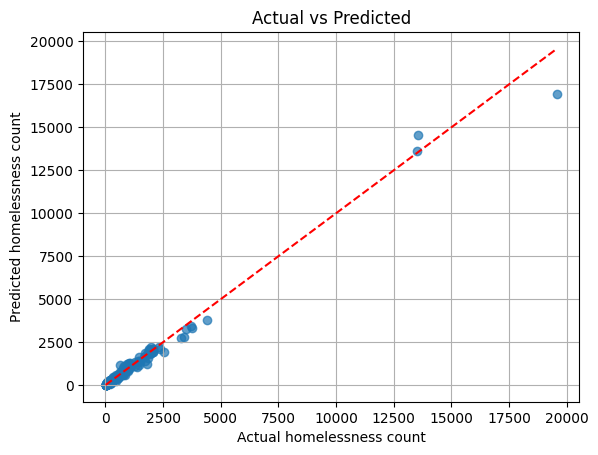

In [27]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

In [28]:
# Get importances
importances = model.feature_importances_

#feature_names = [f"feature_{i}" for i in range(x.shape[1])]
feature_names = x.columns
# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

                                              feature  importance
1                                          POPULATION    0.800456
52                                           AGE__65+    0.040528
46                                      AGE__Under 18    0.029539
47                                         AGE__18-24    0.029173
17                        LOC__Los Angeles County CoC    0.014499
0                                       CALENDAR_YEAR    0.014496
43                            LOC__Ventura County CoC    0.011565
31                             LOC__San Francisco CoC    0.008193
11                           LOC__Humboldt County CoC    0.005358
39                             LOC__Solano County CoC    0.005078
30                          LOC__San Diego County CoC    0.003597
29                     LOC__San Bernardino County CoC    0.002364
48                                         AGE__25-34    0.002350
23                             LOC__Nevada County CoC    0.002349
49        

Results are decent, we're in the right ballpark. The relative error tends to be larger for smaller CoCs which makes sense.

In [29]:
model = RandomForestRegressor(n_estimators = 100, random_state = 0)
model.fit(x, y)

# Get importances
importances = model.feature_importances_

#feature_names = [f"feature_{i}" for i in range(x.shape[1])]
feature_names = x.columns
# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

                                              feature  importance
1                                          POPULATION    0.809365
52                                           AGE__65+    0.038608
47                                         AGE__18-24    0.032344
46                                      AGE__Under 18    0.023747
31                             LOC__San Francisco CoC    0.015120
0                                       CALENDAR_YEAR    0.013114
17                        LOC__Los Angeles County CoC    0.010634
11                           LOC__Humboldt County CoC    0.005423
43                            LOC__Ventura County CoC    0.005123
39                             LOC__Solano County CoC    0.004200
30                          LOC__San Diego County CoC    0.002850
35                      LOC__Santa Barbara County CoC    0.002679
6            LOC__Colusa, Glenn, Trinity Counties CoC    0.002249
51                                         AGE__55-64    0.002105
49        

In [30]:
##To Do: 1. Investigate RF model selection
##### 2. repeat OLS analysis WITHOUT splitting data to see if this ordering holds true.
##### 3. Compare this list to the size of the magnitude of the effects in the linear model to see if they are consistent (interpret interactions in OLS)

Experiment: how many trees?

In [31]:
# scores = []
# num_points = 16
# num_trees = np.floor(np.logspace(0, 4, num=num_points)).astype(int)
# for i, n_estimators in enumerate(num_trees):
#     print(f"{n_estimators} [{i+1}/{num_points}]", end='\r')
#     model = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
#     model.fit(x, y)
#     scores.append(model.score(x, y))

In [32]:
# plt.semilogx(num_trees, scores)
# plt.plot(num_trees, np.ones(num_points), 'r--')
# plt.xlabel("Number of trees")
# plt.ylabel("R² score")

100 trees seems like a sweet spot.

In [33]:
## Prediction Set Example to interpret model


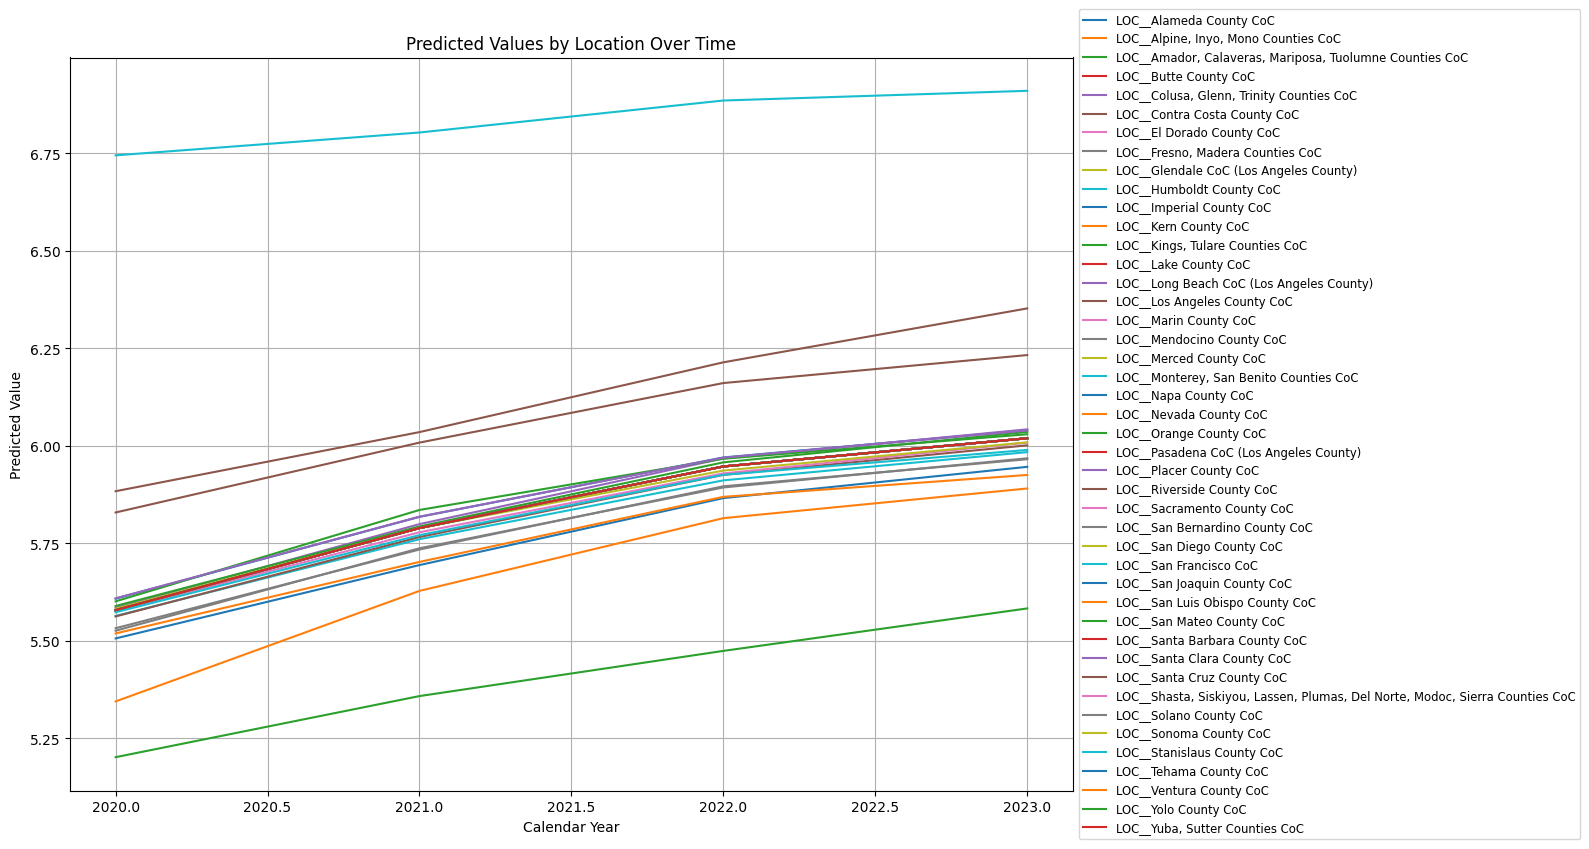

In [34]:
import pandas as pd
import itertools

# Define input values
years = list(range(2020, 2024))  # 2020–2023
locations = [
    'LOC__Alameda County CoC', 'LOC__Alpine, Inyo, Mono Counties CoC',
    'LOC__Amador, Calaveras, Mariposa, Tuolumne Counties CoC', 'LOC__Butte County CoC',
    'LOC__Colusa, Glenn, Trinity Counties CoC', 'LOC__Contra Costa County CoC',
    'LOC__El Dorado County CoC', 'LOC__Fresno, Madera Counties CoC',
    'LOC__Glendale CoC (Los Angeles County)',
    'LOC__Humboldt County CoC', 'LOC__Imperial County CoC', 'LOC__Kern County CoC',
    'LOC__Kings, Tulare Counties CoC', 'LOC__Lake County CoC',
    'LOC__Long Beach CoC (Los Angeles County)', 'LOC__Los Angeles County CoC', 'LOC__Marin County CoC',
    'LOC__Mendocino County CoC', 'LOC__Merced County CoC',
    'LOC__Monterey, San Benito Counties CoC', 'LOC__Napa County CoC',
    'LOC__Nevada County CoC', 'LOC__Orange County CoC', 'LOC__Pasadena CoC (Los Angeles County)',
    'LOC__Placer County CoC',
    'LOC__Riverside County CoC', 'LOC__Sacramento County CoC',
    'LOC__San Bernardino County CoC', 'LOC__San Diego County CoC',
    'LOC__San Francisco CoC', 'LOC__San Joaquin County CoC',
    'LOC__San Luis Obispo County CoC', 'LOC__San Mateo County CoC',
    'LOC__Santa Barbara County CoC', 'LOC__Santa Clara County CoC',
    'LOC__Santa Cruz County CoC',
    'LOC__Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC',
    'LOC__Solano County CoC', 'LOC__Sonoma County CoC', 'LOC__Stanislaus County CoC',
    'LOC__Tehama County CoC', 'LOC__Ventura County CoC', 'LOC__Yolo County CoC',
    'LOC__Yuba, Sutter Counties CoC'
]

age_columns = [
    'AGE__Under 18', 'AGE__18-24', 'AGE__25-34', 'AGE__35-44',
    'AGE__45-54', 'AGE__55-64', 'AGE__65+', 'AGE__Unknown', 'AGE__Invalid'
]

# Replace this with your actual mean
pop_mean = np.log(df['POPULATION'].mean())

# Generate all (year, location) combinations
combos = list(itertools.product(years, locations))

# Build rows
rows = []
for year, loc in combos:
    row = {
        'CALENDAR_YEAR': year,
        'POPULATION': pop_mean,
        **{loc_name: (loc_name == loc) for loc_name in locations},
        **{age: (age == 'AGE__65+') for age in age_columns}
    }
    rows.append(row)

# Create the DataFrame
prediction_df = pd.DataFrame(rows)

# Optional: Reorder columns
ordered_columns = ['CALENDAR_YEAR', 'POPULATION'] + locations + age_columns
prediction_df = prediction_df[ordered_columns]


##Predict
model.predict(prediction_df)


#####PLOT

# 1. Run model prediction
y_pred = model.predict(prediction_df)

# 2. Attach predictions to the DataFrame
prediction_df = prediction_df.copy()
prediction_df['PREDICTED'] = y_pred

# 3. Extract location column names
location_columns = [col for col in prediction_df.columns if col.startswith('LOC__')]

# 4. Melt the DataFrame to long format (one row per location-year pair)
melted = prediction_df.melt(
    id_vars=['CALENDAR_YEAR', 'PREDICTED'],
    value_vars=location_columns,
    var_name='LOCATION',
    value_name='is_active'
)

# 5. Filter to only active location rows
filtered = melted[melted['is_active'] == True]

# 6. Plot each location as a separate line
plt.figure(figsize=(16, 9))

for location in filtered['LOCATION'].unique():
    loc_data = filtered[filtered['LOCATION'] == location]
    plt.plot(loc_data['CALENDAR_YEAR'], loc_data['PREDICTED'], label=location)

plt.title('Predicted Values by Location Over Time')
plt.xlabel('Calendar Year')
plt.ylabel('Predicted Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
import pandas as pd
import itertools

# Define input values
locations = [
    'LOC__Alameda County CoC', 'LOC__Alpine, Inyo, Mono Counties CoC',
    'LOC__Amador, Calaveras, Mariposa, Tuolumne Counties CoC', 'LOC__Butte County CoC',
    'LOC__Colusa, Glenn, Trinity Counties CoC', 'LOC__Contra Costa County CoC',
    'LOC__El Dorado County CoC', 'LOC__Fresno, Madera Counties CoC',
    'LOC__Glendale CoC (Los Angeles County)',
    'LOC__Humboldt County CoC', 'LOC__Imperial County CoC', 'LOC__Kern County CoC',
    'LOC__Kings, Tulare Counties CoC', 'LOC__Lake County CoC',
    'LOC__Long Beach CoC (Los Angeles County)', 'LOC__Los Angeles County CoC', 'LOC__Marin County CoC',
    'LOC__Mendocino County CoC', 'LOC__Merced County CoC',
    'LOC__Monterey, San Benito Counties CoC', 'LOC__Napa County CoC',
    'LOC__Nevada County CoC', 'LOC__Orange County CoC', 'LOC__Pasadena CoC (Los Angeles County)',
    'LOC__Placer County CoC',
    'LOC__Riverside County CoC', 'LOC__Sacramento County CoC',
    'LOC__San Bernardino County CoC', 'LOC__San Diego County CoC',
    'LOC__San Francisco CoC', 'LOC__San Joaquin County CoC',
    'LOC__San Luis Obispo County CoC', 'LOC__San Mateo County CoC',
    'LOC__Santa Barbara County CoC', 'LOC__Santa Clara County CoC',
    'LOC__Santa Cruz County CoC',
    'LOC__Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC',
    'LOC__Solano County CoC', 'LOC__Sonoma County CoC', 'LOC__Stanislaus County CoC',
    'LOC__Tehama County CoC', 'LOC__Ventura County CoC', 'LOC__Yolo County CoC',
    'LOC__Yuba, Sutter Counties CoC'
]

age_columns = [
    'AGE__Under 18', 'AGE__18-24', 'AGE__25-34', 'AGE__35-44',
    'AGE__45-54', 'AGE__55-64', 'AGE__65+', 'AGE__Unknown', 'AGE__Invalid'
]

# Replace this with your actual mean
pop_mean = np.log(df['POPULATION'].mean())

# Build rows
rows = []
for loc in locations:
    row = {
        'CALENDAR_YEAR': year,
        'POPULATION': pop_mean,
        **{loc_name: (loc_name == loc) for loc_name in locations},
        **{age: (age == 'AGE__65+') for age in age_columns}
    }
    rows.append(row)

# Create the DataFrame
prediction_df = pd.DataFrame(rows)

# Optional: Reorder columns
ordered_columns = ['CALENDAR_YEAR', 'POPULATION'] + locations + age_columns
prediction_df = prediction_df[ordered_columns]


##Predict
model.predict(prediction_df)


#####PLOT

# 1. Run model prediction
y_pred = model.predict(prediction_df)

# 2. Attach predictions to the DataFrame
prediction_df = prediction_df.copy()
prediction_df['PREDICTED'] = y_pred

# 3. Extract location column names
location_columns = [col for col in prediction_df.columns if col.startswith('LOC__')]

# 4. Melt the DataFrame to long format (one row per location-year pair)
melted = prediction_df.melt(
    id_vars=['CALENDAR_YEAR', 'PREDICTED'],
    value_vars=location_columns,
    var_name='LOCATION',
    value_name='is_active'
)

# 5. Filter to only active location rows
filtered = melted[melted['is_active'] == True]

# 6. Plot each location as a separate line
# plt.figure(figsize=(16, 9))

# for location in filtered['LOCATION'].unique():
#     loc_data = filtered[filtered['LOCATION'] == location]
#     plt.plot(loc_data['CALENDAR_YEAR'], loc_data['PREDICTED'], 'o', label=location)

# plt.title('Predicted Values by Location Over Time')
# plt.xlabel('Calendar Year')
# plt.ylabel('Predicted Value')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
filtered[['LOCATION', 'PREDICTED']].sort_values('PREDICTED', ascending=False)


,LOCATION,PREDICTED
1305,LOC__San Francisco CoC,6.909377
225,LOC__Contra Costa County CoC,6.351727
675,LOC__Los Angeles County CoC,6.232112
630,LOC__Long Beach CoC (Los Angeles County),6.041767
0,LOC__Alameda County CoC,6.039631
1530,LOC__Santa Clara County CoC,6.038885
990,LOC__Orange County CoC,6.035132
1440,LOC__San Mateo County CoC,6.029245
1935,"LOC__Yuba, Sutter Counties CoC",6.018956
1575,LOC__Santa Cruz County CoC,6.018956


For comparison, let's look at CoCs ordered by population

In [36]:
population_by_region[['LOCATION', '2023']] \
  .drop(population_by_region[population_by_region['LOCATION'].apply(lambda loc: loc == 'California')].index) \
  .sort_values('2023', ascending=False)


,LOCATION,2023
16,Los Angeles County CoC,8814986
29,San Diego County CoC,3285890
23,Orange County CoC,3154563
26,Riverside County CoC,2503549
28,San Bernardino County CoC,2200805
35,Santa Clara County CoC,1897137
0,Alameda County CoC,1638142
27,Sacramento County CoC,1594506
8,"Fresno, Madera Counties CoC",1183301
6,Contra Costa County CoC,1162179


The lists are pretty different. For instance, the prediction is highest in San Francisco CoC yet it's only the 12th most populous CoC. Conversely San Diego CoC is the most populous state but is only 10th on the list.

The other striking thing is that the prediction is identical for 31 CoCs.

# ANCOVA Model

First, let's try on all the data, without splitting.

In [37]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features].copy() # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

x['log_homeless'] = y.copy()

import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
model = smf.ols(formula, data=x).fit()

# Predict
y_pred = model.predict(x)

y_pred = np.exp(y_pred)
y_test = np.exp(y)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 148.770


In [38]:
# Get the coefficients (effects) from the OLS model
ols_coefficients = model.params

# Create a DataFrame for OLS effects
ols_effects_df = pd.DataFrame({
    'ols_coefficient': ols_coefficients.values
}, index=ols_coefficients.index)

# For comparison, we are interested in the absolute magnitude of the coefficients
ols_effects_df['abs_ols_coefficient'] = np.abs(ols_effects_df['ols_coefficient'])

# Sort by absolute magnitude for comparison
ols_effects_df_sorted = ols_effects_df.sort_values(by='abs_ols_coefficient', ascending=False).head(n=25)
print("\nOLS Model - Sorted by Absolute Coefficient Magnitude:")
print(ols_effects_df_sorted["ols_coefficient"])


OLS Model - Sorted by Absolute Coefficient Magnitude:
Intercept                                                                         -256.682927
C(LOCATION)[T.Los Angeles County CoC]                                               -3.034482
C(LOCATION)[T.Lake County CoC]                                                      -2.359268
C(LOCATION)[T.Alpine, Inyo, Mono Counties CoC]                                      -2.352605
C(LOCATION)[T.Nevada County CoC]                                                    -1.983077
C(LOCATION)[T.Imperial County CoC]:C(AGE_GROUP_PUBLIC)[T.55-64]                     -1.854923
C(LOCATION)[T.El Dorado County CoC]                                                 -1.700515
C(LOCATION)[T.Imperial County CoC]:C(AGE_GROUP_PUBLIC)[T.45-54]                     -1.699360
C(LOCATION)[T.Tehama County CoC]                                                    -1.674879
C(LOCATION)[T.Glendale CoC (Los Angeles County)]                                    -1.652643
C(LOC

Contrary to the random forest model, the highest OLS coefficients correspond to locations. _Age group_ is the only non-location in the top 10.

### Conclusions
- The `log_homelessnes` target variable likely has non-linear relationships with POPULATION that the Random Forest is picking up effectively, but the OLS model isn't.

- The effects of `LOCATION` and `AGE_GROUP_PUBLIC` are important in both models, but their linear impact (as seen in OLS) is very strong, while their overall contribution in the non-linear RF model might be overshadowed by `POPULATION`'s pervasive influence.

- The interaction terms in OLS are providing specific insights into how the effect of `AGE_GROUP_PUBLIC__Unknown` varies by `LOCATION`, which is information a simple RF feature importance list doesn't directly provide.

Text(0, 0.5, 'Homelessness')

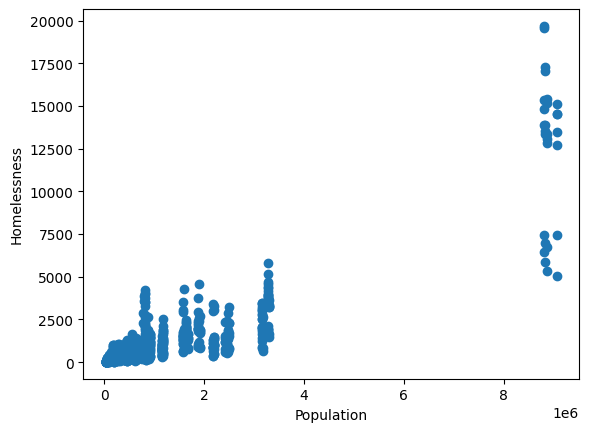

In [39]:
plt.scatter(x['POPULATION'], df['EXPERIENCING_HOMELESSNESS_CNT'])
plt.xlabel('Population')
plt.ylabel('Homelessness')

Text(0, 0.5, 'log(Homelessness)')

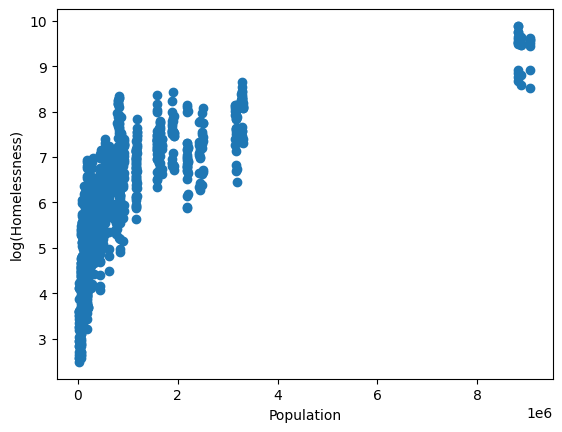

In [40]:
plt.scatter(x['POPULATION'], np.log(df['EXPERIENCING_HOMELESSNESS_CNT']))
plt.xlabel('Population')
plt.ylabel('log(Homelessness)')

Text(0, 0.5, 'log(Homelessness)')

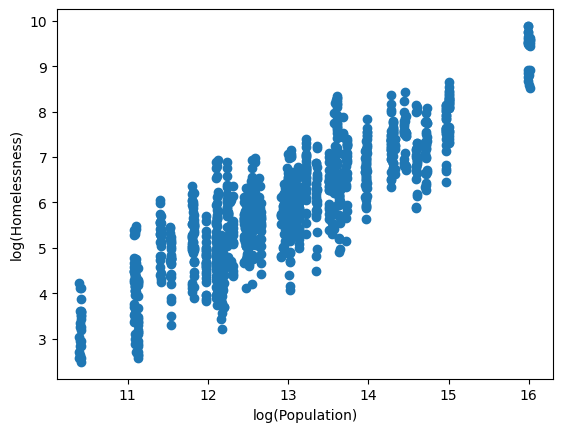

In [41]:
plt.scatter(np.log(x['POPULATION']), np.log(df['EXPERIENCING_HOMELESSNESS_CNT']))
plt.xlabel('log(Population)')
plt.ylabel('log(Homelessness)')

Ok, let's try again with log(population)…

In [42]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features].copy() # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

x['log_homeless'] = y.copy()
x['log_population'] = np.log(df['POPULATION'])

import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + log_population +  CALENDAR_YEAR'
model = smf.ols(formula, data=x).fit()

# Predict
y_pred = model.predict(x)

y_pred = np.exp(y_pred)
y_test = np.exp(y)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 203.255


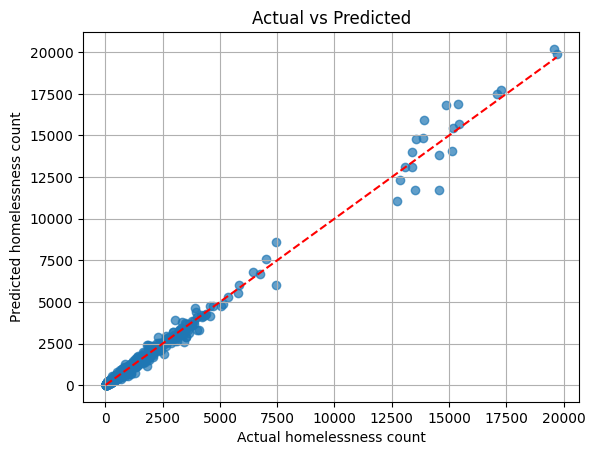

In [43]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

In [44]:
# Get the coefficients (effects) from the OLS model
ols_coefficients = model.params

# Create a DataFrame for OLS effects
ols_effects_df = pd.DataFrame({
    'ols_coefficient': ols_coefficients.values
}, index=ols_coefficients.index)

# For comparison, we are interested in the absolute magnitude of the coefficients
ols_effects_df['abs_ols_coefficient'] = np.abs(ols_effects_df['ols_coefficient'])

# Sort by absolute magnitude for comparison
ols_effects_df_sorted = ols_effects_df.sort_values(by='abs_ols_coefficient', ascending=False)#.head(n=25)
print("\nOLS Model - Sorted by Absolute Coefficient Magnitude:")
with pd.option_context('display.max_rows', None):  # more options can be specified also
    display(ols_effects_df_sorted["ols_coefficient"].filter(regex='^[^:]*$'))


OLS Model - Sorted by Absolute Coefficient Magnitude:


Intercept                                                                                -2.696673e+02
C(LOCATION)[T.San Francisco CoC]                                                          1.252748e+00
C(LOCATION)[T.San Joaquin County CoC]                                                     1.198155e+00
C(LOCATION)[T.Imperial County CoC]                                                        1.138432e+00
C(LOCATION)[T.Yuba, Sutter Counties CoC]                                                  1.085664e+00
C(LOCATION)[T.Mendocino County CoC]                                                       1.034454e+00
C(LOCATION)[T.Solano County CoC]                                                         -1.029459e+00
log_population                                                                            9.762581e-01
C(LOCATION)[T.Colusa, Glenn, Trinity Counties CoC]                                        9.636573e-01
C(LOCATION)[T.Merced County CoC]                                         

While both models highlight the importance of `AGE` and `LOCATION` features, the Random Forest suggests `POPULATION` is paramount due to potentially complex non-linear relationships, whereas the OLS model (especially with interactions) provides specific, interpretable linear insights into how `LOCATION` and `AGE_GROUP_PUBLIC` affect the target, including their modifying effects on each other.

# Predict more targeted model

Try predicting the 65+ population of one county by fixing (removing) all but one parameter at a time.

Let's start with calendar year by fixing the location and age group.

In [45]:
idx = (df["LOCATION"] == "Alameda County CoC") & (df["AGE_GROUP_PUBLIC"] == "65+")
df[idx]

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
1117,2020,CA-502,Alameda County CoC,65+,759.0,[Alameda],1680614
1494,2021,CA-502,Alameda County CoC,65+,864.0,[Alameda],1643856
1867,2022,CA-502,Alameda County CoC,65+,957.0,[Alameda],1635693
2245,2023,CA-502,Alameda County CoC,65+,953.0,[Alameda],1638142


In [46]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features][idx].copy() # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'][idx])  # Target

x['log_homeless'] = y.copy()
x['log_population'] = np.log(df['POPULATION'])

import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + log_population +  CALENDAR_YEAR'
model = smf.ols(formula, data=x).fit()

# Predict
y_pred = model.predict(x)

y_pred = np.exp(y_pred)
y_test = np.exp(y)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 14.095


In [47]:
# Get the coefficients (effects) from the OLS model
ols_coefficients = model.params

# Create a DataFrame for OLS effects
ols_effects_df = pd.DataFrame({
    'ols_coefficient': ols_coefficients.values
}, index=ols_coefficients.index)

# For comparison, we are interested in the absolute magnitude of the coefficients
ols_effects_df['abs_ols_coefficient'] = np.abs(ols_effects_df['ols_coefficient'])

# Sort by absolute magnitude for comparison
ols_effects_df_sorted = ols_effects_df.sort_values(by='abs_ols_coefficient', ascending=False).head(n=25)
print("\nOLS Model - Sorted by Absolute Coefficient Magnitude:")
print(ols_effects_df_sorted["ols_coefficient"])


OLS Model - Sorted by Absolute Coefficient Magnitude:
log_population                   -5.152583e+00
C(AGE_GROUP_PUBLIC)[T.65+]        3.505196e+00
Intercept                         3.505196e+00
CALENDAR_YEAR                     3.637550e-02
C(AGE_GROUP_PUBLIC)[T.25-34]      2.201545e-15
C(AGE_GROUP_PUBLIC)[T.18-24]      4.632819e-17
C(AGE_GROUP_PUBLIC)[T.35-44]      0.000000e+00
C(AGE_GROUP_PUBLIC)[T.45-54]      0.000000e+00
C(AGE_GROUP_PUBLIC)[T.55-64]      0.000000e+00
C(AGE_GROUP_PUBLIC)[T.Unknown]    0.000000e+00
C(AGE_GROUP_PUBLIC)[T.Invalid]    0.000000e+00
Name: ols_coefficient, dtype: float64


Let's now fix the year but vary the location.

In [48]:
idx = (df["CALENDAR_YEAR"] == 2023) & (df["AGE_GROUP_PUBLIC"] == "65+")
df[idx]

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
2227,2023,CA-500,Santa Clara County CoC,65+,911.0,[Santa Clara],1897137
2236,2023,CA-501,San Francisco CoC,65+,922.0,[San Francisco],819151
2245,2023,CA-502,Alameda County CoC,65+,953.0,[Alameda],1638142
2253,2023,CA-503,Sacramento County CoC,65+,785.0,[Sacramento],1594506
2262,2023,CA-504,Sonoma County CoC,65+,311.0,[Sonoma],483366
2270,2023,CA-505,Contra Costa County CoC,65+,796.0,[Contra Costa],1162179
2277,2023,CA-506,"Monterey, San Benito Counties CoC",65+,216.0,"[Monterey, San Benito]",503978
2286,2023,CA-507,Marin County CoC,65+,191.0,[Marin],255706
2294,2023,CA-508,Santa Cruz County CoC,65+,205.0,[Santa Cruz],263699
2303,2023,CA-509,Mendocino County CoC,65+,114.0,[Mendocino],89354


In [49]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features][idx].copy() # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'][idx])  # Target

x['log_homeless'] = y.copy()
x['log_population'] = np.log(df['POPULATION'])

import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + log_population +  CALENDAR_YEAR'
model = smf.ols(formula, data=x).fit()

# Predict
y_pred = model.predict(x)

y_pred = np.exp(y_pred)
y_test = np.exp(y)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 0.000


In [50]:
rmse

np.float64(1.9896737462558027e-10)

In [51]:
# Get the coefficients (effects) from the OLS model
ols_coefficients = model.params

# Create a DataFrame for OLS effects
ols_effects_df = pd.DataFrame({
    'ols_coefficient': ols_coefficients.values
}, index=ols_coefficients.index)

# For comparison, we are interested in the absolute magnitude of the coefficients
ols_effects_df['abs_ols_coefficient'] = np.abs(ols_effects_df['ols_coefficient'])

# Sort by absolute magnitude for comparison
ols_effects_df_sorted = ols_effects_df.sort_values(by='abs_ols_coefficient', ascending=False).head(n=25)
print("\nOLS Model - Sorted by Absolute Coefficient Magnitude:")
print(ols_effects_df_sorted["ols_coefficient"])


OLS Model - Sorted by Absolute Coefficient Magnitude:
log_population                                                                   0.969182
C(LOCATION)[T.San Bernardino County CoC]                                        -0.481846
C(LOCATION)[T.San Bernardino County CoC]:C(AGE_GROUP_PUBLIC)[T.65+]             -0.481846
C(LOCATION)[T.Butte County CoC]:C(AGE_GROUP_PUBLIC)[T.65+]                       0.468296
C(LOCATION)[T.Butte County CoC]                                                  0.468296
C(LOCATION)[T.Humboldt County CoC]                                               0.412071
C(LOCATION)[T.Humboldt County CoC]:C(AGE_GROUP_PUBLIC)[T.65+]                    0.412071
C(LOCATION)[T.Long Beach CoC (Los Angeles County)]                               0.399694
C(LOCATION)[T.Long Beach CoC (Los Angeles County)]:C(AGE_GROUP_PUBLIC)[T.65+]    0.399694
C(LOCATION)[T.El Dorado County CoC]:C(AGE_GROUP_PUBLIC)[T.65+]                  -0.388373
C(LOCATION)[T.El Dorado County CoC]          

Let's try fixing the location and year and keep the age groups for good measure.

In [52]:
idx = (df["CALENDAR_YEAR"] == 2023) & (df["LOCATION"] == "Alameda County CoC")
df[idx]

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION
2240,2023,CA-502,Alameda County CoC,18-24,1127.0,[Alameda],1638142
2241,2023,CA-502,Alameda County CoC,25-34,2442.0,[Alameda],1638142
2242,2023,CA-502,Alameda County CoC,35-44,2361.0,[Alameda],1638142
2243,2023,CA-502,Alameda County CoC,45-54,2046.0,[Alameda],1638142
2244,2023,CA-502,Alameda County CoC,55-64,2108.0,[Alameda],1638142
2245,2023,CA-502,Alameda County CoC,65+,953.0,[Alameda],1638142
2246,2023,CA-502,Alameda County CoC,Under 18,2308.0,[Alameda],1638142


In [53]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features][idx].copy() # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'][idx])  # Target

x['log_homeless'] = y.copy()
x['log_population'] = np.log(df['POPULATION'])

import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + log_population +  CALENDAR_YEAR'
model = smf.ols(formula, data=x).fit()

# Predict
y_pred = model.predict(x)

y_pred = np.exp(y_pred)
y_test = np.exp(y)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 0.000


In [54]:
# Get the coefficients (effects) from the OLS model
ols_coefficients = model.params

# Create a DataFrame for OLS effects
ols_effects_df = pd.DataFrame({
    'ols_coefficient': ols_coefficients.values
}, index=ols_coefficients.index)

# For comparison, we are interested in the absolute magnitude of the coefficients
ols_effects_df['abs_ols_coefficient'] = np.abs(ols_effects_df['ols_coefficient'])

# Sort by absolute magnitude for comparison
ols_effects_df_sorted = ols_effects_df.sort_values(by='abs_ols_coefficient', ascending=False).head(n=25)
print("\nOLS Model - Sorted by Absolute Coefficient Magnitude:")
print(ols_effects_df_sorted["ols_coefficient"])


OLS Model - Sorted by Absolute Coefficient Magnitude:
C(AGE_GROUP_PUBLIC)[T.65+]       -0.884522
C(AGE_GROUP_PUBLIC)[T.18-24]     -0.716822
C(AGE_GROUP_PUBLIC)[T.45-54]     -0.120495
C(AGE_GROUP_PUBLIC)[T.55-64]     -0.090642
C(AGE_GROUP_PUBLIC)[T.25-34]      0.056436
C(AGE_GROUP_PUBLIC)[T.35-44]      0.022704
CALENDAR_YEAR                     0.003828
log_population                    0.000027
Intercept                         0.000002
C(AGE_GROUP_PUBLIC)[T.Unknown]    0.000000
C(AGE_GROUP_PUBLIC)[T.Invalid]    0.000000
Name: ols_coefficient, dtype: float64


## Back to regular ANCOVA

Now let's split 80%/20%.

In [55]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])
#x = x.copy()  # Avoid SettingWithCopyWarning
#x['POPULATION'] = np.log(x['POPULATION'].astype(float))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [56]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
model = smf.ols(formula, data=train_data).fit()

#print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

RMSE: 164.714


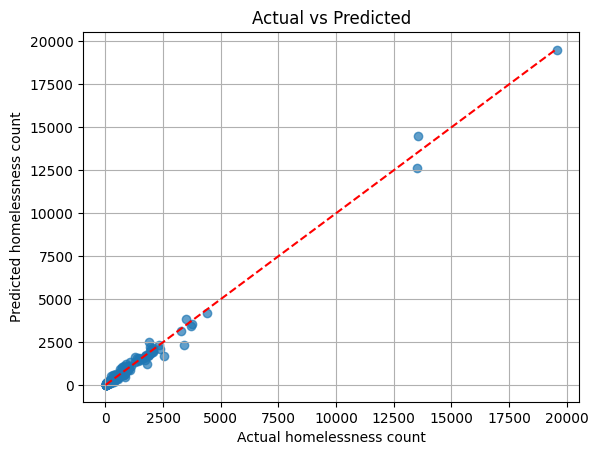

In [57]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

More investigation needed, but if we ignore the 1-2 point(s) that seems to have WAY underpredicted in the homelessness, this may be the better model and has the added benefit of interpretability. 

In [58]:
formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
model = smf.ols(formula, data=train_data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_homeless   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     119.0
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:57:36   Log-Likelihood:                 300.93
No. Observations:                 980   AIC:                             18.14
Df Residuals:                     670   BIC:                             1533.
Df Model:                         309                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================================================
                                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                              -272.2270     13.113    -20.760      0.000    -297.974    -246.480
C(LOCATION)[T.Alpine, Inyo, Mono Counties CoC]                                                                           -2.3735      0.679     -3.496      0.001      -3.707      -1.040
C(LOCATION)[T.Amador, Calaveras, Mariposa, Tuolumne Counties CoC]                                                        -1.0357      0.622     -1.666      0.096      -2.256       0.185
C(LOCATION)[T.Butte County CoC]                                                                                          -0.4570      0.606     -0.754      0.451      -1.646       0.732
C(LOCATION)[T.Colusa, Glenn, Trinity Counties CoC]                                                                       -1.0663      0.657     -1.622      0.105      -2.357       0.225
C(LOCATION)[T.Contra Costa County CoC]                                                                                   -0.1366      0.264     -0.518      0.604      -0.654       0.381
C(LOCATION)[T.El Dorado County CoC]                                                                                      -1.6694      0.611     -2.732      0.006      -2.869      -0.469
C(LOCATION)[T.Fresno, Madera Counties CoC]                                                                               -0.0121      0.253     -0.048      0.962      -0.508       0.484
C(LOCATION)[T.Glendale CoC (Los Angeles County)]                                                                         -1.6456      0.607     -2.709      0.007      -2.838      -0.453
C(LOCATION)[T.Humboldt County CoC]                                                                                       -0.7483      0.634     -1.180      0.238      -1.993       0.497
C(LOCATION)[T.Imperial County CoC]                                                                                        0.0014      0.614      0.002      0.998      -1.203       1.206
C(LOCATION)[T.Kern County CoC]                                                                                            0.2382      0.339      0.702      0.483      -0.428       0.904
C(LOCATION)[T.Kings, Tulare Counties CoC]                                                                                 0.2344      0.453      0.517      0.605      -0.656       1.124
C(LOCATION)[T.Lake County CoC]                                                                             

## Predict age group

Rather than a 80%/20% training/test split, we now want to predict data for an entire age group.

This is an extrapolation problem since the age group categories are unrelated (one-hot encoded) so we don't expect to do as well.

We try to predict the 65+ age group.

In [59]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)

In [60]:
test_mask = df['AGE_GROUP_PUBLIC'] == '65+'
train_mask = ~test_mask
x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [61]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [62]:
y_pred = model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

Once again, let's compute the same error metrics.

In [63]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
1100,2020,Santa Clara County CoC,65+,1924802,892.0,1859.224422,967.224422,935523.082193,108.4%
1108,2020,San Francisco CoC,65+,874826,788.0,1758.822938,970.822938,942497.177825,123.2%
1117,2020,Alameda County CoC,65+,1680614,759.0,1399.742828,640.742828,410551.371147,84.4%
1126,2020,Sacramento County CoC,65+,1586727,572.0,1336.052788,764.052788,583776.662885,133.6%
1135,2020,Sonoma County CoC,65+,488501,242.0,463.323675,221.323675,48984.169333,91.5%
...,...,...,...,...,...,...,...,...,...
2556,2023,San Bernardino County CoC,65+,2200805,484.0,1126.799816,642.799816,413191.603187,132.8%
2564,2023,Ventura County CoC,65+,833071,386.0,521.511148,135.511148,18363.271146,35.1%
2573,2023,Glendale CoC (Los Angeles County),65+,192270,112.0,125.182353,13.182353,173.774442,11.8%
2580,2023,Imperial County CoC,65+,180585,52.0,96.952535,44.952535,2020.730411,86.4%


In [64]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

##635 with no log: worse here?

RMSE: 1462.006


The result are pretty bad, like 100% relative error, but this is expected for an extrapolation problem.

## Geography

What if we include geographical data, like the graph of neighboring CoCs for each CoC.

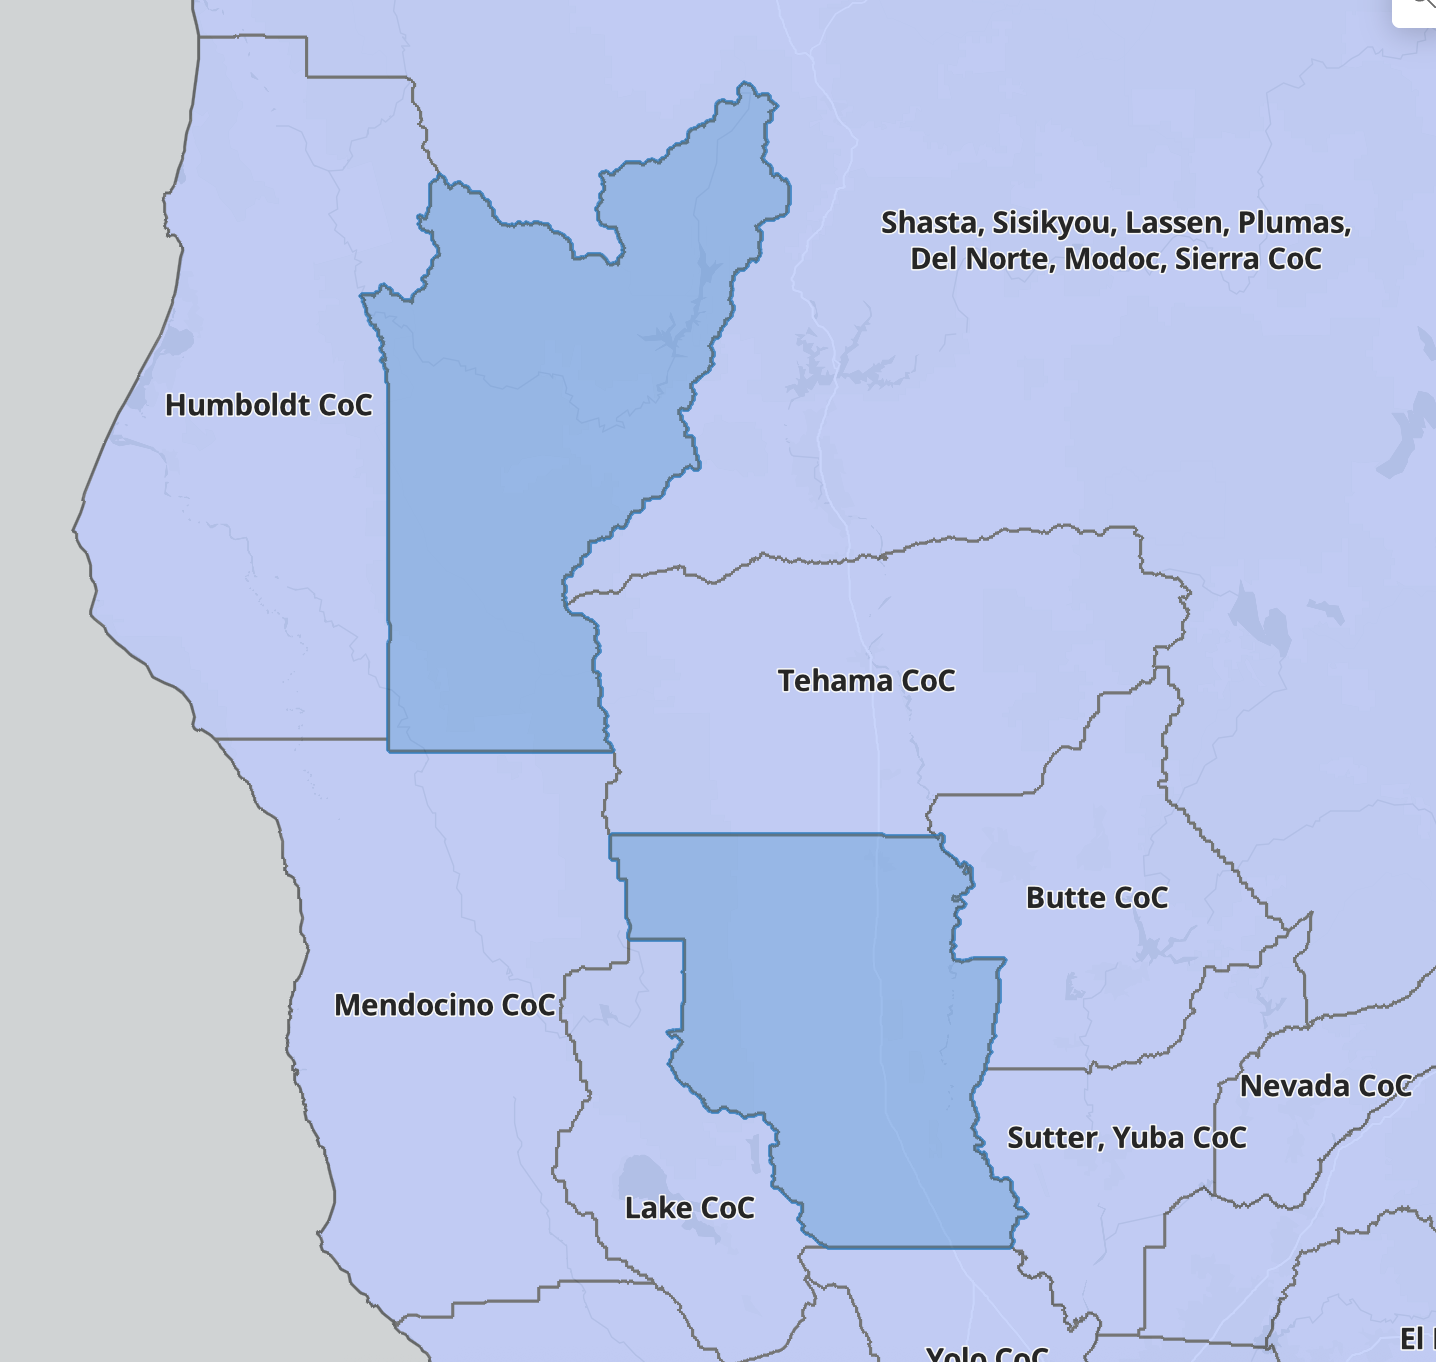
_Of course, geography is complicated. Here is a disjoint CoC._

The following is painstakingly manually extracted from this [interactive map][1].

[1]: https://experience.arcgis.com/experience/7227e954a08a4d2cb990949aa029275d/page/Find-Your-CoC/.

In [65]:
neighbors = {
    "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC": [
        "Humboldt County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Tehama County CoC",
        "Butte County CoC",
        "Yuba, Sutter Counties CoC",
        "Nevada County CoC",
    ],
    "Humboldt County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Mendocino County CoC",
    ],
    "Colusa, Glenn, Trinity Counties CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Humboldt County CoC",
        "Tehama County CoC",
        "Mendocino County CoC",
        "Lake County CoC",
        "Butte County CoC",
        "Yuba, Sutter Counties CoC",
        "Yolo County CoC",
    ],
    "Tehama County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Mendocino County CoC",
        "Butte County CoC",
    ],
    "Butte County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Tehama County CoC",
        "Yuba, Sutter Counties CoC",
    ],
    "Yuba, Sutter Counties CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Butte County CoC",
        "Nevada County CoC",
        "Placer County CoC",
    ],
    "Nevada County CoC": [
        "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC",
        "Yuba, Sutter Counties CoC",
        "Placer County CoC",
    ],
    "Placer County CoC": [
        "Nevada County CoC",
        "Yuba, Sutter Counties CoC",
        "Sacramento County CoC",
        "El Dorado County CoC",
    ],
    "Mendocino County CoC": [
        "Humboldt County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Tehama County CoC",
        "Lake County CoC",
        "Sonoma County CoC",
    ],
    "Lake County CoC": [
        "Mendocino County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Sonoma County CoC",
        "Napa County CoC",
        "Yolo County CoC",
    ],
    "Sonoma County CoC": [
        "Mendocino County CoC",
        "Lake County CoC",
        "Napa County CoC",
        "Marin County CoC",
    ],
    "Napa County CoC": [
        "Sonoma County CoC",
        "Lake County CoC",
        "Yolo County CoC",
        "Solano County CoC",
    ],
    "Yolo County CoC": [
        "Lake County CoC",
        "Colusa, Glenn, Trinity Counties CoC",
        "Yuba, Sutter Counties CoC",
        "Sacramento County CoC",
        "Solano County CoC",
        "Napa County CoC",
    ],
    "Sacramento County CoC": [
        "Yolo County CoC",
        "Yuba, Sutter Counties CoC",
        "Placer County CoC",
        "El Dorado County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "San Joaquin County CoC",
        "Contra Costa County CoC",
        "Solano County CoC",
    ],
    "El Dorado County CoC": [
        "Placer County CoC",
        "Sacramento County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
    ],
    "Marin County CoC": [
        "Sonoma County CoC",
        "Contra Costa County CoC",
        "San Francisco CoC",
    ],
    "Solano County CoC": [
        "Napa County CoC",
        "Yolo County CoC",
        "Sacramento County CoC",
        "Contra Costa County CoC",
    ],
    "Contra Costa County CoC": [
        "Marin County CoC",
        "Solano County CoC",
        "Sacramento County CoC",
        "San Joaquin County CoC",
        "Alameda County CoC",
    ],
    "San Joaquin County CoC": [
        "Alameda County CoC",
        "Contra Costa County CoC",
        "Sacramento County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Stanislaus County CoC",
        "Santa Clara County CoC",
    ],
    "Amador, Calaveras, Mariposa, Tuolumne Counties CoC": [
        "Sacramento County CoC",
        "El Dorado County CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Fresno, Madera Counties CoC",
        "Merced County CoC",
        "Stanislaus County CoC",
        "San Joaquin County CoC",
    ],
    "Alpine, Inyo, Mono Counties CoC": [
        "El Dorado County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Fresno, Madera Counties CoC",
        "Kings, Tulare Counties CoC",
        "Kern County CoC",
        "San Bernardino County CoC",
    ],
    "San Francisco CoC": [
        "Marin County CoC",
        "Alameda County CoC",
        "San Mateo County CoC",
    ],
    "Alameda County CoC": [
        "San Francisco CoC",
        "San Mateo County CoC",
        "Contra Costa County CoC",
        "San Joaquin County CoC",
        "Santa Clara County CoC",
    ],
    "San Mateo County CoC": [
        "San Francisco CoC",
        "Alameda County CoC",
        "Santa Clara County CoC",
        "Santa Cruz County CoC",
    ],
    "Santa Cruz County CoC": [
        "San Mateo County CoC",
        "Santa Clara County CoC",
        "Monterey, San Benito Counties CoC",
    ],
    "Santa Clara County CoC": [
        "Santa Cruz County CoC",
        "San Mateo County CoC",
        "Alameda County CoC",
        "Stanislaus County CoC",
        "Merced County CoC",
        "Monterey, San Benito Counties CoC",
    ],
    "Stanislaus County CoC": [
        "Santa Clara County CoC",
        "San Joaquin County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Merced County CoC",
    ],
    "Merced County CoC": [
        "Stanislaus County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Santa Clara County CoC",
        "Monterey, San Benito Counties CoC",
        "Fresno, Madera Counties CoC",
    ],
    "Monterey, San Benito Counties CoC": [
        "Santa Cruz County CoC",
        "Santa Clara County CoC",
        "Merced County CoC",
        "Fresno, Madera Counties CoC",
        "Kings, Tulare Counties CoC",
        "San Luis Obispo County CoC",
    ],
    "Fresno, Madera Counties CoC": [
        "Monterey, San Benito Counties CoC",
        "Merced County CoC",
        "Amador, Calaveras, Mariposa, Tuolumne Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Kings, Tulare Counties CoC",
    ],
    "Kings, Tulare Counties CoC": [
        "Monterey, San Benito Counties CoC",
        "Fresno, Madera Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Kern County CoC",
    ],
    "San Luis Obispo County CoC": [
        "Monterey, San Benito Counties CoC",
        "Kern County CoC",
        "Santa Barbara County CoC",
    ],
    "Kern County CoC": [
        "San Luis Obispo County CoC",
        "Kings, Tulare Counties CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "San Bernardino County CoC",
        "Los Angeles CoC",
        "Ventura County CoC",
    ],
    "San Bernardino County CoC": [
        "Kern County CoC",
        "Alpine, Inyo, Mono Counties CoC",
        "Riverside County CoC",
        "Orange County CoC",
        "Los Angeles CoC",
    ],
    "Santa Barbara County CoC": [
        "San Luis Obispo County CoC",
        "Ventura County CoC",
    ],
    "Ventura County CoC": [
        "Santa Barbara County CoC",
        "Kern County CoC",
        "Los Angeles CoC",
    ],
    "Los Angeles County CoC": [
        "Glendale CoC (Los Angeles County)",
        "Pasadena CoC (Los Angeles County)",
        "Long Beach CoC (Los Angeles County)",
        "Ventura County CoC",
        "Kern County CoC",
        "San Bernardino County CoC",
        "Orange County CoC",
    ],
    "Glendale CoC (Los Angeles County)": [
        "Los Angeles CoC",
        "Pasadena CoC (Los Angeles County)",
    ],
    "Pasadena CoC (Los Angeles County)": [
        "Los Angeles CoC",
        "Glendale CoC (Los Angeles County)",
    ],
    "Long Beach CoC (Los Angeles County)": [
        "Los Angeles CoC",
        "Orange County CoC",
    ],
    "Orange County CoC": [
        "Los Angeles CoC",
        "Long Beach CoC (Los Angeles County)",
        "San Bernardino County CoC",
        "Riverside County CoC",
        "San Diego County CoC",
    ],
    "Riverside County CoC": [
        "San Bernardino County CoC",
        "Orange County CoC",
        "San Diego County CoC",
        "Imperial County CoC",
    ],
    "San Diego County CoC": [
        "Orange County CoC",
        "Riverside County CoC",
        "Imperial County CoC",
    ],
    "Imperial County CoC": [
        "Riverside County CoC",
        "San Diego County CoC",
    ],
}

Apply one-hot encoding.

In [66]:
def normalize(loc):
    return loc.replace(' ', '_').replace(',', '_').replace('(', '_').replace(')', '_').replace('__', '_')

df["NEIGHBORS"] = df.LOCATION.apply(lambda loc: neighbors[loc])
for loc, neigh in neighbors.items():
    df[f"NEAR_{normalize(loc)}"] = df.LOCATION.apply(lambda l: l in neigh)
df

,CALENDAR_YEAR,LOCATION_ID,LOCATION,AGE_GROUP_PUBLIC,EXPERIENCING_HOMELESSNESS_CNT,COUNTIES,POPULATION,NEIGHBORS,NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_Modoc_Sierra_Counties_CoC,NEAR_Humboldt_County_CoC,...,NEAR_Santa_Barbara_County_CoC,NEAR_Ventura_County_CoC,NEAR_Los_Angeles_County_CoC,NEAR_Glendale_CoC_Los_Angeles_County_,NEAR_Pasadena_CoC_Los_Angeles_County_,NEAR_Long_Beach_CoC_Los_Angeles_County_,NEAR_Orange_County_CoC,NEAR_Riverside_County_CoC,NEAR_San_Diego_County_CoC,NEAR_Imperial_County_CoC
1095,2020,CA-500,Santa Clara County CoC,18-24,831.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1096,2020,CA-500,Santa Clara County CoC,25-34,1729.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1097,2020,CA-500,Santa Clara County CoC,35-44,1863.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1098,2020,CA-500,Santa Clara County CoC,45-54,1758.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
1099,2020,CA-500,Santa Clara County CoC,55-64,1880.0,[Santa Clara],1924802,"[Santa Cruz County CoC, San Mateo County CoC, ...",False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586,2023,CA-614,San Luis Obispo County CoC,35-44,564.0,[San Luis Obispo],282007,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,True,False,False,False,False,False,False,False,False,False
2587,2023,CA-614,San Luis Obispo County CoC,45-54,438.0,[San Luis Obispo],282007,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,True,False,False,False,False,False,False,False,False,False
2588,2023,CA-614,San Luis Obispo County CoC,55-64,351.0,[San Luis Obispo],282007,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,True,False,False,False,False,False,False,False,False,False
2589,2023,CA-614,San Luis Obispo County CoC,65+,219.0,[San Luis Obispo],282007,"[Monterey, San Benito Counties CoC, Kern Count...",False,False,...,True,False,False,False,False,False,False,False,False,False


Run the same 80%/20% training/test split with the additional data.

In [67]:
x = df[features + [f"NEAR_{normalize(loc)}" for loc in neighbors.keys()]]
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

In [68]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

,CALENDAR_YEAR,LOCATION,AGE_GROUP_PUBLIC,POPULATION,ACTUAL,PRED,ABS_ERROR,SQ_ERROR,REL_ERROR
1597,2021,Placer County CoC,35-44,412968,370.0,385.834715,15.834715,250.738215,4.3%
1787,2021,Riverside County CoC,35-44,2455225,1304.0,1304.448025,0.448025,0.200727,0.0%
1153,2020,"Monterey, San Benito Counties CoC",Under 18,505039,751.0,600.810822,150.189178,22556.789308,20.0%
1853,2022,San Francisco CoC,18-24,814176,1660.0,1601.397445,58.602555,3434.259423,3.5%
1986,2022,Napa County CoC,18-24,134492,61.0,87.320502,26.320502,692.768834,43.1%
...,...,...,...,...,...,...,...,...,...
2587,2023,San Luis Obispo County CoC,45-54,282007,438.0,429.556169,8.443831,71.298279,1.9%
2437,2023,El Dorado County CoC,55-64,192440,93.0,86.274199,6.725801,45.236399,7.2%
1179,2020,Stanislaus County CoC,18-24,553710,422.0,417.095554,4.904446,24.053594,1.2%
2507,2023,Orange County CoC,Under 18,3154563,3483.0,3054.793116,428.206884,183361.135223,12.3%


In [69]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

##257 without log transform

RMSE: 226.974


RMSE was 284 so we get about 10% improvement by taking into account the geography (as a graph of connected CoCs).

### Now apply on all training data

In [70]:
x = df[features + [f"NEAR_{normalize(loc)}" for loc in neighbors.keys()]]
x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x, y)

RandomForestRegressor(n_estimators=10, random_state=0)

In [71]:
x.columns

Index(['CALENDAR_YEAR', 'POPULATION',
       'NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_Modoc_Sierra_Counties_CoC',
       'NEAR_Humboldt_County_CoC', 'NEAR_Colusa_Glenn_Trinity_Counties_CoC',
       'NEAR_Tehama_County_CoC', 'NEAR_Butte_County_CoC',
       'NEAR_Yuba_Sutter_Counties_CoC', 'NEAR_Nevada_County_CoC',
       'NEAR_Placer_County_CoC', 'NEAR_Mendocino_County_CoC',
       'NEAR_Lake_County_CoC', 'NEAR_Sonoma_County_CoC',
       'NEAR_Napa_County_CoC', 'NEAR_Yolo_County_CoC',
       'NEAR_Sacramento_County_CoC', 'NEAR_El_Dorado_County_CoC',
       'NEAR_Marin_County_CoC', 'NEAR_Solano_County_CoC',
       'NEAR_Contra_Costa_County_CoC', 'NEAR_San_Joaquin_County_CoC',
       'NEAR_Amador_Calaveras_Mariposa_Tuolumne_Counties_CoC',
       'NEAR_Alpine_Inyo_Mono_Counties_CoC', 'NEAR_San_Francisco_CoC',
       'NEAR_Alameda_County_CoC', 'NEAR_San_Mateo_County_CoC',
       'NEAR_Santa_Cruz_County_CoC', 'NEAR_Santa_Clara_County_CoC',
       'NEAR_Stanislaus_County_CoC', 'NEAR_Merc

In [72]:
import pandas as pd
import itertools

# Define input values
locations = [
    'LOC__Alameda County CoC',
    'LOC__Alpine, Inyo, Mono Counties CoC',
    'LOC__Amador, Calaveras, Mariposa, Tuolumne Counties CoC',
    'LOC__Butte County CoC', 'LOC__Colusa, Glenn, Trinity Counties CoC',
    'LOC__Contra Costa County CoC', 'LOC__El Dorado County CoC',
    'LOC__Fresno, Madera Counties CoC',
    'LOC__Glendale CoC (Los Angeles County)', 'LOC__Humboldt County CoC',
    'LOC__Imperial County CoC', 'LOC__Kern County CoC',
    'LOC__Kings, Tulare Counties CoC', 'LOC__Lake County CoC',
    'LOC__Long Beach CoC (Los Angeles County)',
    'LOC__Los Angeles County CoC', 'LOC__Marin County CoC',
    'LOC__Mendocino County CoC', 'LOC__Merced County CoC',
    'LOC__Monterey, San Benito Counties CoC', 'LOC__Napa County CoC',
    'LOC__Nevada County CoC', 'LOC__Orange County CoC',
    'LOC__Pasadena CoC (Los Angeles County)', 'LOC__Placer County CoC',
    'LOC__Riverside County CoC', 'LOC__Sacramento County CoC',
    'LOC__San Bernardino County CoC', 'LOC__San Diego County CoC',
    'LOC__San Francisco CoC', 'LOC__San Joaquin County CoC',
    'LOC__San Luis Obispo County CoC', 'LOC__San Mateo County CoC',
    'LOC__Santa Barbara County CoC', 'LOC__Santa Clara County CoC',
    'LOC__Santa Cruz County CoC',
    'LOC__Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC',
    'LOC__Solano County CoC', 'LOC__Sonoma County CoC',
    'LOC__Stanislaus County CoC', 'LOC__Tehama County CoC',
    'LOC__Ventura County CoC', 'LOC__Yolo County CoC',
    'LOC__Yuba, Sutter Counties CoC',
]

near_locs = [
    'NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_Modoc_Sierra_Counties_CoC',
    'NEAR_Humboldt_County_CoC', 'NEAR_Colusa_Glenn_Trinity_Counties_CoC',
    'NEAR_Tehama_County_CoC', 'NEAR_Butte_County_CoC',
    'NEAR_Yuba_Sutter_Counties_CoC', 'NEAR_Nevada_County_CoC',
    'NEAR_Placer_County_CoC', 'NEAR_Mendocino_County_CoC',
    'NEAR_Lake_County_CoC', 'NEAR_Sonoma_County_CoC',
    'NEAR_Napa_County_CoC', 'NEAR_Yolo_County_CoC',
    'NEAR_Sacramento_County_CoC', 'NEAR_El_Dorado_County_CoC',
    'NEAR_Marin_County_CoC', 'NEAR_Solano_County_CoC',
    'NEAR_Contra_Costa_County_CoC', 'NEAR_San_Joaquin_County_CoC',
    'NEAR_Amador_Calaveras_Mariposa_Tuolumne_Counties_CoC',
    'NEAR_Alpine_Inyo_Mono_Counties_CoC', 'NEAR_San_Francisco_CoC',
    'NEAR_Alameda_County_CoC', 'NEAR_San_Mateo_County_CoC',
    'NEAR_Santa_Cruz_County_CoC', 'NEAR_Santa_Clara_County_CoC',
    'NEAR_Stanislaus_County_CoC', 'NEAR_Merced_County_CoC',
    'NEAR_Monterey_San_Benito_Counties_CoC',
    'NEAR_Fresno_Madera_Counties_CoC', 'NEAR_Kings_Tulare_Counties_CoC',
    'NEAR_San_Luis_Obispo_County_CoC', 'NEAR_Kern_County_CoC',
    'NEAR_San_Bernardino_County_CoC', 'NEAR_Santa_Barbara_County_CoC',
    'NEAR_Ventura_County_CoC', 'NEAR_Los_Angeles_County_CoC',
    'NEAR_Glendale_CoC_Los_Angeles_County_',
    'NEAR_Pasadena_CoC_Los_Angeles_County_',
    'NEAR_Long_Beach_CoC_Los_Angeles_County_', 'NEAR_Orange_County_CoC',
    'NEAR_Riverside_County_CoC', 'NEAR_San_Diego_County_CoC',
    'NEAR_Imperial_County_CoC',
 ]

age_columns = [
    'AGE__Under 18', 'AGE__18-24', 'AGE__25-34', 'AGE__35-44',
    'AGE__45-54', 'AGE__55-64', 'AGE__65+', 'AGE__Unknown', 'AGE__Invalid'
]

# Replace this with your actual mean
pop_mean = np.log(df['POPULATION'].mean())

# Generate all (location, near_loc) combinations
combos = list(itertools.product(locations, near_locs))


# Build rows
rows = []
for loc, near_loc in combos:
    row = {
        'CALENDAR_YEAR': 2025,
        'POPULATION': pop_mean,
        **{loc_name: (loc_name == near_loc) for loc_name in near_locs},
        **{loc_name: (loc_name == loc) for loc_name in locations},
        **{age: (age == 'AGE__65+') for age in age_columns},
    }
    rows.append(row)

# Create the DataFrame
prediction_df = pd.DataFrame(rows)

# Optional: Reorder columns
ordered_columns = ['CALENDAR_YEAR', 'POPULATION'] + near_locs + locations + age_columns
prediction_df = prediction_df[ordered_columns]


##Predict
model.predict(prediction_df)


#####PLOT

# 1. Run model prediction
y_pred = model.predict(prediction_df)

# 2. Attach predictions to the DataFrame
prediction_df = prediction_df.copy()
prediction_df['PREDICTED'] = y_pred

# 3. Extract location column names
location_columns = [col for col in prediction_df.columns if col.startswith('LOC__')]
near_columns = [col for col in prediction_df.columns if col.startswith('NEAR_')]
distance_columns = [col for col in prediction_df.columns if col.startswith('DIST_')]

# 4. Melt the DataFrame to long format (one row per location-year pair)
melted = prediction_df.melt(
    id_vars=['CALENDAR_YEAR', 'PREDICTED'] + near_locs,
    value_vars=location_columns,
    var_name='LOCATION',
    value_name='is_active'
)
melted = melted.melt(
    id_vars=['CALENDAR_YEAR', 'PREDICTED', 'LOCATION', 'is_active'],
    value_vars=near_columns,
    var_name='NEAR',
    value_name='is_adjacent'
)

# 5. Filter to only active location rows
filtered = melted[melted['is_active'] == True]
filtered = filtered[filtered['is_adjacent'] == True]

filtered[['LOCATION', 'NEAR', 'PREDICTED']].sort_values('PREDICTED', ascending=False)

,LOCATION,NEAR,PREDICTED
0,LOC__Alameda County CoC,NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_M...,3.411898
45540,LOC__Pasadena CoC (Los Angeles County),NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_M...,3.411898
49500,LOC__Riverside County CoC,NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_M...,3.411898
51480,LOC__Sacramento County CoC,NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_M...,3.411898
53460,LOC__San Bernardino County CoC,NEAR_Shasta_Siskiyou_Lassen_Plumas_Del_Norte_M...,3.411898
...,...,...,...
1236150,LOC__Orange County CoC,NEAR_El_Dorado_County_CoC,2.705963
1238130,LOC__Pasadena CoC (Los Angeles County),NEAR_El_Dorado_County_CoC,2.705963
1240110,LOC__Placer County CoC,NEAR_El_Dorado_County_CoC,2.705963
1242090,LOC__Riverside County CoC,NEAR_El_Dorado_County_CoC,2.705963


<Axes: xlabel='NEAR', ylabel='LOCATION'>

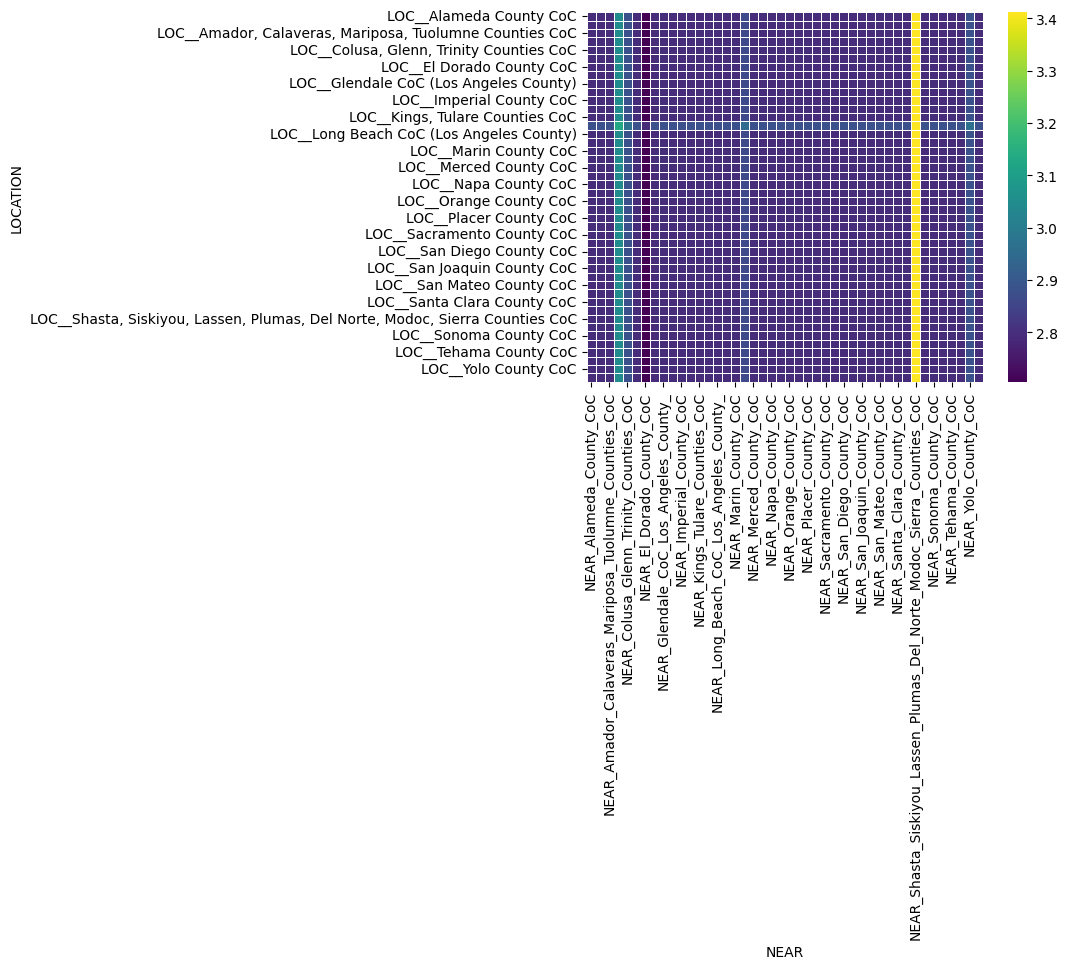

In [73]:
heat = filtered[['LOCATION', 'NEAR', 'PREDICTED']].pivot(index='LOCATION', columns='NEAR', values='PREDICTED')
sns.heatmap(heat, cmap='viridis', linewidths=.5)

### Mixed Effects Models with Spatial location

In [74]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features + [f"NEAR_{normalize(loc)}" for loc in neighbors.keys()]] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')
# for loc in neighbors.keys():
    # train_data[f"NEAR_{normalize(loc)}"] = train_data[f"NEAR_{normalize(loc)}"].astype('float64')
    # train_data[f"NEAR_{normalize(loc)}"] = train_data[f"NEAR_{normalize(loc)}"].astype('category')
    # train_data[f"NEAR_{normalize(loc)}"] -= 0.5
    # print(train_data[f"NEAR_{normalize(loc)}"])
    # break

train_data['NEAR_Humboldt_County_CoC'] = train_data['NEAR_Humboldt_County_CoC'].astype('category')
x_test['NEAR_Humboldt_County_CoC'] = x_test['NEAR_Humboldt_County_CoC'].astype('category')

In [75]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    'log_homeless ~ C(AGE_GROUP_PUBLIC) + POPULATION + CALENDAR_YEAR',
    data=train_data,
    groups=train_data['LOCATION']
).fit(method='lbfgs')

print(model.summary())

y_pred = model.predict(x_test)

y_pred = np.exp(y_pred)
y_test =np.exp(y_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

LinAlgError: Singular matrix

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Topological distance

In [ ]:
import collections

def calculate_topological_distances(graph_data):
    """
    Calculates the topological distance (number of hops) between all pairs of nodes
    in an unweighted graph using Breadth-First Search (BFS).

    Args:
        graph_data (dict): A dictionary representing the adjacency list of the graph.
                           Keys are node names, and values are lists of their neighbors.

    Returns:
        pandas.DataFrame: A DataFrame where both index and columns are node names,
                          and values are the topological distances.
                          Returns float('inf') if nodes are unreachable.
    """
    # Create a set of all unique CoC names to ensure all nodes are included
    all_coc_names = set(graph_data.keys())
    for neighbors_list in graph_data.values():
        all_coc_names.update(neighbors_list)
    all_coc_names = sorted(list(all_coc_names))

    # Build a symmetric adjacency list to ensure bidirectional connections
    # This is crucial for accurate distance calculations in an undirected graph.
    symmetric_graph = {coc: set() for coc in all_coc_names}
    for node, neighbors_list in graph_data.items():
        for neighbor in neighbors_list:
            symmetric_graph[node].add(neighbor)
            symmetric_graph[neighbor].add(node) # Ensure symmetry

    # Initialize a dictionary to store all-pairs distances
    all_pairs_distances = {}

    # Perform BFS from each CoC to find distances to all other CoCs
    for start_node in all_coc_names:
        distances = {node: float('inf') for node in all_coc_names}
        distances[start_node] = 0
        queue = collections.deque([start_node])

        while queue:
            current_node = queue.popleft()

            # Iterate over neighbors, ensuring they exist in the symmetric_graph
            for neighbor in symmetric_graph.get(current_node, []):
                if distances[neighbor] == float('inf'):
                    distances[neighbor] = distances[current_node] + 1
                    queue.append(neighbor)
        all_pairs_distances[start_node] = distances

    # Convert the results into a pandas DataFrame
    distance_df = pd.DataFrame(all_pairs_distances)
    # Reorder columns and index to be consistent
    distance_df = distance_df.reindex(index=all_coc_names, columns=all_coc_names)

    return distance_df

# Calculate the topological distances
topological_distances_df = calculate_topological_distances(neighbors)

In [ ]:
def add_topological_distance_columns(df, location_column, topological_distances_df):
    """
    Adds new columns to a DataFrame, representing the topological distance from
    the CoC in the specified location_column to all other CoCs.

    Args:
        df (pandas.DataFrame): The input DataFrame with a CoC name column.
        location_column (str): The name of the column in df that contains CoC names.
        topological_distances_df (pandas.DataFrame): The DataFrame containing
                                                     all-pairs topological distances.

    Returns:
        pandas.DataFrame: The DataFrame with added distance columns.
    """
    # Get the list of all CoC names from the topological_distances_df columns
    all_coc_names = topological_distances_df.columns.tolist()

    # Create new columns for distances, initialized to NaN
    for coc_name in all_coc_names:
        df[f'DIST_{normalize(coc_name)}'] = float('nan')

    # Populate the new distance columns
    for index, row in df.iterrows():
        current_coc = row[location_column]
        if current_coc in topological_distances_df.index:
            # Get the row of distances for the current CoC
            distances_from_current_coc = topological_distances_df.loc[current_coc]
            for other_coc in all_coc_names:
                df.at[index, f'DIST_{normalize(other_coc)}'] = distances_from_current_coc.get(other_coc, float('inf'))
        else:
            print(f"Warning: CoC '{current_coc}' not found in topological distances. Skipping row {index}.")

    return df

In [ ]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = add_topological_distance_columns(df[features].copy(), 'LOCATION', topological_distances_df) # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [ ]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
formula += " + "
formula += " + ".join([f"DIST_{normalize(loc)}" for loc in neighbors.keys()])
model = smf.ols(formula, data=train_data).fit()

# print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.3f'))

#model.summary()

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Average neighbor population

In [ ]:
def add_average_neighbor_population(df, location_column, population_column, graph_data):
    """
    Adds a new column to the DataFrame with the average population of neighboring CoCs.

    Args:
        df (pandas.DataFrame): The input DataFrame with CoC names and population.
        location_column (str): The name of the column in df that contains CoC names.
        population_column (str): The name of the column in df that contains population data.
        graph_data (dict): The adjacency list of the graph (e.g., `neighbors` dictionary).

    Returns:
        pandas.DataFrame: The DataFrame with the 'AVG_NEIGHBOR_POPULATION' column added.
    """
    # Create a mapping of CoC to Population for efficient lookup
    coc_population_map = df.set_index(location_column)[population_column].to_dict()

    # Build a symmetric adjacency list for accurate neighbor lookup
    all_coc_names = set(graph_data.keys())
    for neighbors_list in graph_data.values():
        all_coc_names.update(neighbors_list)
    symmetric_graph = {coc: set() for coc in all_coc_names}
    for node, neighbors_list in graph_data.items():
        for neighbor in neighbors_list:
            symmetric_graph[node].add(neighbor)
            symmetric_graph[neighbor].add(node) # Ensure symmetry

    # Initialize the new column
    df['AVG_NEIGHBOR_POPULATION'] = float('nan')

    for index, row in df.iterrows():
        current_coc = row[location_column]
        if current_coc in symmetric_graph:
            neighbors_of_current_coc = symmetric_graph[current_coc]
            neighbor_populations = []
            for neighbor_coc in neighbors_of_current_coc:
                if neighbor_coc in coc_population_map:
                    neighbor_populations.append(coc_population_map[neighbor_coc])
                else:
                    print(f"Warning: Population for neighbor '{neighbor_coc}' of '{current_coc}' not found in DataFrame. Skipping.")

            if neighbor_populations:
                df.at[index, 'AVG_NEIGHBOR_POPULATION'] = sum(neighbor_populations) / len(neighbor_populations)
            else:
                df.at[index, 'AVG_NEIGHBOR_POPULATION'] = 0 # Or np.nan, depending on desired behavior for CoCs with no populated neighbors
        else:
            print(f"Warning: CoC '{current_coc}' not found in graph data. Cannot calculate average neighbor population for row {index}.")

    return df

In [ ]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = add_average_neighbor_population(df[features].copy(), 'LOCATION', 'POPULATION', neighbors) # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [ ]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
formula += ' + AVG_NEIGHBOR_POPULATION'
model = smf.ols(formula, data=train_data).fit()

# print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.9f'))

#model.summary()

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

### Lattitude / longitude

In [ ]:
def add_average_coc_lat_long(df, coc_names, county_lat_lng_path="data/us_county_latlng.csv"):
    """
    Computes the average latitude and longitude for each Continuum of Care (CoC) area
    based on the lat/long of its constituent counties.

    Args:
        df (pd.DataFrame): A dataframe
        coc_names (list): A list of CoC names (strings) for which to compute lat/long.
                          These names are expected to follow the convention:
                          "County1, County2, ... Counties CoC" or "County1 County CoC".
        county_lat_lng_url (str): URL to a CSV file containing county latitude and longitude data.
                                  Expected columns: 'fips_code', 'name', 'lat', 'lng'.

    Returns:
        pandas.DataFrame: A DataFrame with 'CoC_Name', 'Avg_Latitude', and 'Avg_Longitude' columns.
    """
    try:
        # Load county latitude/longitude data
        county_data = pd.read_csv(county_lat_lng_path, dtype={'fips_code': str})
        # Filter for California counties and convert county names to lowercase for robust matching
        ca_county_data = county_data[county_data['fips_code'].str.startswith('06')].copy()
        ca_county_data['county_name_lower'] = ca_county_data['name'].str.lower()
        county_lat_lng_map = ca_county_data.set_index('county_name_lower')[['lat', 'lng']].to_dict('index')
    except Exception as e:
        raise RuntimeError(f"Error loading or processing county lat/lng data from {county_lat_lng_path}: {e}")

    for coc_name in coc_names:
        # Extract county names from the CoC name
        # Remove " Counties CoC" or " County CoC" and then split by comma
        cleaned_name = re.sub(r'( Counties CoC| County CoC| CoC)$', '', coc_name)
        # Handle cases like "Alpine, Inyo, Mono Counties CoC"
        # and "Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC"
        counties_in_coc = [c.strip().lower() for c in cleaned_name.split(',')]

        total_lat = 0
        total_lng = 0
        found_counties_count = 0
        missing_counties = []

        for county in counties_in_coc:
            # Handle specific naming discrepancies if known, e.g., "del norte" vs "del-norte"
            # For now, rely on direct lowercased match.
            if county in county_lat_lng_map:
                total_lat += county_lat_lng_map[county]['lat']
                total_lng += county_lat_lng_map[county]['lng']
                found_counties_count += 1
            else:
                missing_counties.append(county)

        if found_counties_count > 0:
            avg_lat = total_lat / found_counties_count
            avg_lng = total_lng / found_counties_count
        else:
            avg_lat = float('nan')
            avg_lng = float('nan')
            print(f"Warning: No valid county lat/long data found for CoC '{coc_name}'. Missing counties: {missing_counties}")

        df.loc[df['LOCATION'] == coc_name, 'LATTITUDE'] = avg_lat
        df.loc[df['LOCATION'] == coc_name, 'LONGITUDE'] = avg_lng

    return df

In [ ]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = add_average_coc_lat_long(df[features].copy(), neighbors.keys()) # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

#x['POPULATION'] = np.log(x['POPULATION'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
train_data = x_train.copy()
train_data['log_homeless'] = y_train

train_data['LOCATION'] = train_data['LOCATION'].astype('category')
train_data['AGE_GROUP_PUBLIC'] = train_data['AGE_GROUP_PUBLIC'].astype('category')

In [ ]:
import statsmodels.formula.api as smf

formula = 'log_homeless ~ C(LOCATION) * C(AGE_GROUP_PUBLIC) + POPULATION +  CALENDAR_YEAR'
formula += ' + LATTITUDE + LONGITUDE'
model = smf.ols(formula, data=train_data).fit()

# print(model.summary())

test_data = x_test.copy()

# Predict
y_pred = model.predict(test_data)

y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", format(rmse, '.9f'))

#model.summary()

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual homelessness count")
plt.ylabel("Predicted homelessness count")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

## Try predicting one missing county for last year

In [ ]:
features = ['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION']

x = df[features] # Features
y = np.log(df['EXPERIENCING_HOMELESSNESS_CNT'])  # Target

x = pd.get_dummies(pd.get_dummies(x, columns=['LOCATION'], prefix='LOC_'), columns=['AGE_GROUP_PUBLIC'], prefix='AGE_')

In [ ]:
test_mask = (df.LOCATION == 'Alameda County CoC') & (df.CALENDAR_YEAR == 2024)
train_mask = ~test_mask
x_train = x[train_mask]
x_test = x[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [ ]:
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
pred = x_test.copy()
pred['LOCATION'] = df['LOCATION'][pred.index]
pred['AGE_GROUP_PUBLIC'] = df['AGE_GROUP_PUBLIC'][pred.index]
pred['ACTUAL'] = y_test
pred['PRED'] = y_pred
pred['ABS_ERROR'] = np.abs(y_test - y_pred)
pred['SQ_ERROR'] = (y_test - y_pred)**2
pred['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(y_test, y_pred)]
pred[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'POPULATION', 'ACTUAL', 'PRED', 'ABS_ERROR', 'SQ_ERROR', 'REL_ERROR']]

In [ ]:
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
print("RMSE:", format(rmse, '.3f'))
##129 without log transform

Predictably, the results are good because the test data is much smaller than the training data, and we're interpolating. The _Unknown_ age group is completely off but this one feels like an exception.

## Compare actual with prediction when leaving one out

We'll do the same thing as above but systematically, by leaving one year/CoC/age group at a time and comparing the prediction to the actual data.

The goal is to identify the _surprise_ which might indicate CoCs doing something right (or wrong) for a certain year/age group, which we might be able to correlate with funding, policies, etc.

In [ ]:
res = x.copy()

def pred(series):
    print(series.name)
    test_mask = df.index == series.name
    train_mask = ~test_mask
    x_train = x[train_mask]
    x_test = x[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    model = RandomForestRegressor(n_estimators = 10, random_state = 0)
    model.fit(x_train, y_train)
    return pd.Series([model.predict(x_test)[0], y_test.iloc[0]], index=['PRED', 'ACTUAL'])

res['LOCATION'] = df.LOCATION[res.index]
res['AGE_GROUP_PUBLIC'] = df.AGE_GROUP_PUBLIC[res.index]
res[['PRED', 'ACTUAL']] = res.apply(pred, axis=1)
res['ABS_ERROR'] = np.abs(res.PRED - res.ACTUAL)
res['SQ_ERROR'] = (res.PRED - res.ACTUAL)**2
res['REL_ERROR'] = [f"{np.abs((y_test1 - y_pred1) / y_test1) * 100:.1f}%" for y_test1, y_pred1 in zip(res.ACTUAL, res.PRED)]
res

Show more compact results.

In [ ]:
res['DIFF'] = (res.PRED - res.ACTUAL) / res.ACTUAL
res['DIFF%'] = [f"{((y_pred1 - y_actual1) / y_actual1) * 100:.1f}%" for y_pred1, y_actual1 in zip(res.PRED, res.ACTUAL)]
small = res[['CALENDAR_YEAR', 'LOCATION', 'AGE_GROUP_PUBLIC', 'ACTUAL', 'DIFF', 'DIFF%']]
small[small.AGE_GROUP_PUBLIC.apply(lambda g: g not in ["Invalid", "Unknown"])].sort_values("DIFF")